
# Presidential Tweet Sorting with SVM and Naive Bayes Classifiers

__Project Summary:__

Our goal is to design and compare linear Support Vector Machine (SVM) and Naive Bayes classifiers to sort tweets made by Hillary Clinton and Donald Trump during the 2016 presidential campaign, based on the following features:
  1. Vocabulary content alone;
  2. Vocabulary content augmented by additional features, e.g., average word length, hashtag count, and sentiment polarity score.

For each case we use several performance metrics to compare the SVM's performance to that of a Naive Bayes classifier.  We conclude that:
  * When applied to feature vectors based on vocabulary list word stems alone, the Naive Bayes classifier performs as well as the SVM (85% accuracy).
  * When the features are augmented by the additional features: 
    * Both the SVM and the Naive Bayes classifiers improve substantially.  
    * The SVM provides a small advantage over the Naive Bayes classifier (95% vs. 93% accuracy).
  * To the extent that processing time and/or computational resources are a concern, the Naive Bayes classifier provides an efficient, although slightly inferior alternative to the SVM classifier.

----

__Outline:__ 

  1. __Scraping and Cleaning Twitter Data__
    - 1.1 Getting the tweets
    - 1.2 Getting the tweet meta-data
    - 1.3 Loading the data frame
    - 1.4 Limiting the data set

  2. __Generating New Features__
    - 2.1 Adding new features
    - 2.2 New features: data exploration
  3. __NLP: Identifying the Most Frequent Words__
    - 3.1 Tokenizing
    - 3.2 Excluding stop words
    - 3.3 Word stemming
    - 3.4 The NLP Pipeline
    - 3.5 Exploratory analysis: Clinton and Trump tweets
    - 3.6 Building a vocabulary list from Trump campaign speeches
  4. __Sentiment Analysis (Sad!)__
    - 4.1 VADER analysis with `nltk.sentiment` 
    - 4.2 Results
  5. __The SVM Classifier: Vocabulary List Features Only__
    - 5.1 The _ABCs_ of SVMs
    - 5.2 Our SVM: an overview
    - 5.3 Generating feature vectors
    - 5.4 Dividing the training/cross-validation/test data
    - 5.5 Forming the feature matrix `X` and label vector `y`
    - 5.6 Training the SVM; selecting the penalty parameter _C_
    - 5.7 Running the test set
    - 5.8 Performance assessment
  6. __The SVM Classifier: With New Features Added__
    - 6.1 Re-training the SVM
    - 6.2 Performance assessment
  7. __Comparison to Naive Bayes__
    - 7.1 Naive Bayes: vocabulary list features only
    - 7.2 Naive Bayes: with new features
    - 7.3 Conclusions
----




## 1. Scraping and Cleaning Twitter Data

Our first step is to obtain all tweets by Trump (@RealDonaldTrump) and Clinton (@HillaryClinton).  Twitter makes it annoyingly difficult to use their API to scrape all tweets by a specified user.  We'll use some Python libraries to automate this process by doing the following for a specified a user handle and range of dates:

  1. Using the `Selenium` library to open Twitter's search page in a browser, obtain the tweet IDs for all tweets by the user on each day in the date range, and write them to a .json file.
  2. Using `Tweepy` to obtain the meta-data for each tweet ID (the tweet's datetime stamp, number of retweets, etc.).  via Twitter's API.  The tweets and their meta-data are then written to a final output .json file.  

Rather than reinvent the wheel, we'll adapt our code from the [Trump Twitter Archive](http://www.trumptwitterarchive.com) scraping code, available on GitHub [here](https://github.com/bpb27/twitter_scraping).

### 1.1 Getting the tweets

In [1]:
% matplotlib inline

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import os
import csv
import json
import datetime
import re
import nltk
import copy
import scipy.optimize 
from sklearn import svm

# additional libraries used by the tweet scraping code
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException, StaleElementReferenceException
from time import sleep
import tweepy
import math
import glob
import zipfile
import zlib
from tweepy import TweepError

First we'll define the function that uses the `selenium` library to scrape the IDs for all tweets by a specified user within a specified date range.  We'll save those IDs to a file called `all_ids.json`.  Later we'll use these IDs, together with the `tweepy` library, to obtain the metadata for each tweet.

In [5]:
def scrape_tweets(user='realdonaldtrump'): # user: 'realdonaldtrump', HillaryClinton'
    start = datetime.datetime(2009, 1, 1)  # year, month, day
    end = datetime.datetime(2017, 2, 1)  # year, month, day

    delay = 1  # time to wait on each page load before reading the page
    driver = webdriver.Safari() # webdriver to auto-open twitter pages in Safari browser

    twitter_ids_filename = 'all_ids.json'
    days = (end - start).days + 1
    id_selector = '.time a.tweet-timestamp'
    tweet_selector = 'li.js-stream-item'
    user = user.lower()
    ids = []

    def format_day(date):
        day = '0' + str(date.day) if len(str(date.day)) == 1 else str(date.day)
        month = '0' + str(date.month) if len(str(date.month)) == 1 else str(date.month)
        year = str(date.year)
        return '-'.join([year, month, day])

    def form_url(since, until):
        p1 = 'https://twitter.com/search?f=tweets&vertical=default&q=from%3A'
        p2 =  user + '%20since%3A' + since + '%20until%3A' + until + 'include%3Aretweets&src=typd'
        return p1 + p2

    def increment_day(date, i):
        return date + datetime.timedelta(days=i)

    for day in range(days): # loop to get tweets from Twitter URL for each day
        d1 = format_day(increment_day(start, 0))
        d2 = format_day(increment_day(start, 1))
        url = form_url(d1, d2)
        print(url)
        print(d1)
        driver.get(url)
        sleep(delay)

        try:
            found_tweets = driver.find_elements_by_css_selector(tweet_selector)
            increment = 10

            while len(found_tweets) >= increment:
                print('scrolling down to load more tweets')
                driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                sleep(delay)
                found_tweets = driver.find_elements_by_css_selector(tweet_selector)
                increment += 10

            print('{} tweets found, {} total'.format(len(found_tweets), len(ids)))

            for tweet in found_tweets:
                try:
                    id = tweet.find_element_by_css_selector(id_selector).get_attribute('href').split('/')[-1]
                    ids.append(id)
                except StaleElementReferenceException as e:
                    print('lost element reference', tweet)

        except NoSuchElementException:
            print('no tweets on this day')

        start = increment_day(start, 1)


    try: 
        with open(twitter_ids_filename) as f:
            all_ids = ids + json.load(f)
            data_to_write = list(set(all_ids))
            print('tweets found on this scrape: ', len(ids))
            print('total tweet count: ', len(data_to_write))
    except: # if file doesn't yet exist:
        with open(twitter_ids_filename, 'w') as f:
            all_ids = ids
            data_to_write = list(set(all_ids))
            print('tweets found on this scrape: ', len(ids))
            print('total tweet count: ', len(data_to_write))

    with open(twitter_ids_filename, 'w') as outfile:
        json.dump(data_to_write, outfile)

    print('all done here')
    driver.close()

### 1.2 Getting the tweet meta-data:

Now we'll use the `tweepy` library to get the meta-data for each tweet ID.  This requires using Twitter's API.  To avoid displaying my API keys here, I'll load them from a file called `api_keys.json` that doesn't appear in this repository.

The resulting output files for each Twitter username will be written to an output folder names `[twitter username]_tweets`.  Each folder contains 4 output files:
  1. `[username].json`: a master file with all tweet metadata
  2. `[username].zip`: a zipped file of the master file with all metadata
  3. `[username]_short.json`: a smaller master file containing only relevant metadata fields
  4. `[username].csv`: a csv version of the smaller master file

Later we'll use file number (3) to load the relevant metadata for each tweet into a `Pandas` data frame.

In [6]:
def get_metadata(user, output_foldername):
    with open('api_keys.json') as f:
        keys = json.load(f)

    auth = tweepy.OAuthHandler(keys['consumer_key'], keys['consumer_secret'])
    auth.set_access_token(keys['access_token'], keys['access_token_secret'])
    api = tweepy.API(auth)
    user = user.lower()
    output_file = '{}.json'.format(user)
    output_file_short = '{}_short.json'.format(user)
    compression = zipfile.ZIP_DEFLATED

    with open('all_ids.json') as f:
        ids = json.load(f)

    print('total ids: {}'.format(len(ids)))

    all_data = []
    start = 0
    end = 100
    limit = len(ids)
    i = math.ceil(limit / 100)

    for go in range(int(i)): # get tweets in batches of 100
        print('currently getting {} - {}'.format(start, end))
        sleep(6)  # needed to prevent hitting API rate limit
        id_batch = ids[start:end]
        start += 100
        end += 100
        tweets = api.statuses_lookup(id_batch)
        for tweet in tweets:
            all_data.append(dict(tweet._json))

    print('metadata collection complete')
    print('creating master json file')
    with open(output_file, 'w') as outfile:
        json.dump(all_data, outfile)

    print('creating ziped master json file')
    zf = zipfile.ZipFile('{}.zip'.format(user), mode='w')
    zf.write(os.path.join(output_foldername, output_file), compress_type=compression)
    zf.close()

    results = []

    def is_retweet(entry):
        return 'retweeted_status' in entry.keys()

    def get_source(entry):
        if '<' in entry["source"]:
            return entry["source"].split('>')[1].split('<')[0]
        else:
            return entry["source"]

    with open(output_file) as json_data:
        data = json.load(json_data)
        for entry in data:
            t = {
                "created_at": entry["created_at"],
                "text": entry["text"],
                "in_reply_to_screen_name": entry["in_reply_to_screen_name"],
                "retweet_count": entry["retweet_count"],
                "favorite_count": entry["favorite_count"],
                "source": get_source(entry),
                "id_str": entry["id_str"],
                "is_retweet": is_retweet(entry)
            }
            results.append(t)

    print('creating minimized json master file')
    with open(os.path.join(output_foldername, output_file_short), 'w') as outfile:
        json.dump(results, outfile)

    with open(os.path.join(output_foldername, output_file_short)) as master_file:
        data = json.load(master_file)
        fields = ["favorite_count", "source", "text", "in_reply_to_screen_name", "is_retweet", 
                  "created_at", "retweet_count", "id_str"]
        print('creating CSV version of minimized json master file')
        f = csv.writer(open(os.path.join(output_foldername, '{}.csv'.format(user)), 'w'))
        f.writerow(fields)
        for x in data:
            f.writerow([x["favorite_count"], x["source"], x["text"], x["in_reply_to_screen_name"], 
                        x["is_retweet"], x["created_at"], x["retweet_count"], x["id_str"]])

Now we'll run the code for each of Trump and Clinton's handles:

In [7]:
for user, foldername in zip(['realdonaldtrump', 'hillaryclinton'],
                            ['trump_tweets', 'clinton_tweets']):
    if not os.path.isdir('%s' % foldername):
        scrape_tweets(user) # scrapes the relevant tweet IDs
        get_metadata(user)  # saves the tweets and metadata to .json file

### 1.3 Loading the data frame

All of our data is saved in a collection of .json files in named folders, with the form: 

`[username]_tweets/[username]_short.json`

Let's load the data into a singe `Pandas` data frame, print some summary information about the data frame, and have a quick look at its first few rows:

In [8]:
def load_tweet_dataframe():
    users = ['Trump', 'Clinton']
    usernames = ['realdonaldtrump', 'hillaryclinton']
    df = pd.DataFrame()
    for user, username in zip(users, usernames):
        user_df = pd.read_json('./%s_tweets/%s_short.json' % (user.lower(), username))
        user_df['user'] = user
        df = df.append(user_df, ignore_index=True)
    return df

df = load_tweet_dataframe()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36692 entries, 0 to 36691
Data columns (total 9 columns):
created_at                 36692 non-null datetime64[ns]
favorite_count             36692 non-null int64
id_str                     36692 non-null int64
in_reply_to_screen_name    3059 non-null object
is_retweet                 36692 non-null bool
retweet_count              36692 non-null int64
source                     36692 non-null object
text                       36692 non-null object
user                       36692 non-null object
dtypes: bool(1), datetime64[ns](1), int64(3), object(4)
memory usage: 2.3+ MB


,created_at,favorite_count,id_str,in_reply_to_screen_name,is_retweet,retweet_count,source,text,user
0,2013-05-20 10:09:49,24,336423508580118528,None,False,25,Twitter for Android,"""@j_cohl: I'm kinda hoping that @realDonaldTru...",Trump
1,2013-03-29 18:10:03,174,317700194269552640,None,False,287,Twitter Web Client,Have a great Good Friday and a Happy Easter.,Trump
2,2013-07-13 00:02:07,4,355839520194838528,None,False,5,Twitter for Android,"""@JewelsInLotus: @realDonaldTrump @BG9half @Th...",Trump
3,2017-01-14 13:07:12,77031,820255947956383744,None,False,16606,Twitter for Android,mention crime infested) rather than falsely co...,Trump
4,2014-11-24 21:38:39,1387,536997346585096192,None,False,1296,Twitter Web Client,ISIS is starting its own currency. May be stro...,Trump


Just for kicks, let's have a peek at the first Clinton and Trump tweets in our data frame:

In [9]:
print 'Trump:\n', df[df.user=='Trump'].reset_index()['text'][0], '\n'
print 'Clinton:\n', df[df.user=='Clinton'].reset_index()['text'][0]

Trump:
"@j_cohl: I'm kinda hoping that @realDonaldTrump and @IvankaTrump become the first father-daughter US President duo in American history CUTE 

Clinton:
You shouldn’t have to be rich to make your voice heard. Hillary on why it’s time to reverse Citizens United: https://t.co/0JXLzK1MMD


## 1.4 Limiting the data set

We'll limit our analysis to the subset of the data defined by two limitations:
  1. __Trump: Android tweets only:__ For Trump, we'll begin by limiting ourselves to the subset of tweets that includes only Trump tweets made from Trump's Android phone.  Some clever analysis [shown here](http://varianceexplained.org/r/trump-tweets/) indicates that genuine tweets by Trump originated from his Android phone, with other tweets (by campaign staffers) originating from other platforms listed under the `source` column in our data frame.  Later, we can choose to compare our results to an analysis that includes all Trump tweets.
  2. __Trump and Clinton: after Jan. 1, 2015 only:__ We'll limit ourselves to tweets with a `created_at` date on or after January 1, 2015,  coinciding with the approximate start of the political campaign.  

These limitations are motivated by two considerations.  
  - First, we would like the Trump tweets we analyze to be similar to our corpus of Trump vocabulary terms, which will be culled from the text of Trump's campaign speeches.  
  - Second, it will ensure that the size of our Trump and Clinton data sets are roughly equal (see just below).

For convenience __we'll define `trump` and `clinton` boolean arrays we can use to select rows from the data frame.__  These arrays identify: 
  * `trump`: all tweets after Jan. 1, 2015 that came from Trump's Android phone.
  * `clinton`: all tweets after Jan. 1, 2015 (regardless of source).

In [10]:
clinton = (df['user']=='Clinton') & (df['created_at'] > '2015-01-01')
trump = (df['user']=='Trump') & (df['created_at'] > '2015-01-01') & \
        (df['source']=='Twitter for Android')

num_clinton = df[clinton].created_at.count()
num_trump = df[trump].created_at.count()
num_total = num_clinton + num_trump

print 'Total Clinton tweets in df subset:\t %s (%.1f%%)' % (num_clinton, 100.*num_clinton/num_total)
print 'Total Trump tweets in df subset:\t %s (%.1f%%)' % (num_trump, 100.*num_trump/num_total)

Total Clinton tweets in df subset:	 7082 (51.0%)
Total Trump tweets in df subset:	 6795 (49.0%)


----
# 2. Generating New Features

The data frame we've loaded contains some useful, basic information (datetime, tweet text, etc.).  Below we've defined some helper functions we'll use to generate some additional features that might prove useful.  Some possible parameters we will explore include:
  * __Vocabulary content:__ Spam filters work by culling the most common word stems from a corpus of known spam e-mails, then comparing the contents of e-mails for overlap.  We might do something similar with Trump tweets.
  * __Word length:__  The longest word in Mr. Trump's assertion that "I know words; I have the best words" is the word "words," measuring five characters in length.  Can Trump tweets be distinguished by their average or maximum word length (excluding uninformative strings like URLs)?
  * __Number of "!"s__: Many Presidential tweets contain an unusually large number of exclamation points.
  * __Hashtag (#) count:__ Trump and Clinton may have different tendencies to use hashtags.
  * __Mention (@) count:__ Likewise for mentions.
  * __ALL-CAPS ratio:__ A high count of the number of words tweeted ENTIRELY IN CAPITAL LETTERS might be a reliable indicator that the tweet came from Trump.
  * __Quotations:__ Trump has a tendency to "manually" retweet by copying and pasting others' tweets and enclosing them in quotation marks.  A quotation mark at the start of a tweet may be a useful indicator.
  * __Time of day:__ Was the tweet sent at 3:00 a.m.?  It may have come from the President of the United States.
  * __Tweet sentiment:__ A considerable fraction of Mr. Trump's tweets have negative emotional valence.  __We'll visit the code for this feature further below in part 4.__

__Caution:__ note that some of these features will have degeneracies; for example, we can expect the maximum word length to be correlated with the average word length.  We'll have to keep this in mind when deciding which features we'll ultimately use in our sorting algorithm.

## 2.1 Adding new features

In [11]:
def get_wordcount(text):
    strings = text.replace('-', ' ').split()
    return len(strings)

def get_valid_words(words):
    '''
    A function to exclude URLs, Twitter handles, and hashtags 
    from a list of words.  These tend to be long and/or
    uninformative when counting, e.g., a tweet's average wordlength.
    '''
    valid_words = [w for w in words if '@' not in w  # mentions; e-mail addresses
                   and '#' not in w[:2]              # to capture quoted hashtags
                   and 'www.' not in w and 'http' not in w]
    return valid_words
    
def get_avg_wordlength(text):
    words = text.replace('-', ' ').split()
    valid_words = get_valid_words(words)
    if len(valid_words) == 0:
        return 0
    avg_length = sum(float(len(word)) for word in 
                     valid_words) / float(len(valid_words))
    return avg_length

def get_max_wordlength(text): 
    words = text.replace('-', ' ').split()
    valid_words = get_valid_words(words)
    if len(valid_words) == 0:
        return 0
    return len(max(valid_words, key=len))

def get_longest_word(text): 
    words = text.replace('-', ' ').split()
    valid_words = get_valid_words(words)
    if len(valid_words) == 0:
        return 'NONE'
    return max(valid_words, key=len)

def get_hashtag_count(text):
    words = text.split()
    hashtags = [w for w in words if '#' in w[:2]] # to capture quotations
    return len(hashtags)

def get_mention_count(text):
    words = text.split()
    mentions = [w for w in words if '@' in w[:2]] # to capture quotations
    return len(mentions)

def contains_picture(text):
    return ('t.co' in text.split('/'))

def is_quotation(text):
    return text.startswith('"')

def get_time_of_day(datetime):
    hour, minutes = datetime.hour, datetime.minute
    return float(hour) + minutes/60.

def get_exclamation_count(text):
    return text.count('!')
    
def get_allcaps_ratio(text):
    strings = text.replace('-', ' ').split()
    count = len([re.compile('[^a-zA-Z]+').sub('', s) for s in strings if s.isupper() 
                 and len(re.compile('[^a-zA-Z]+').sub('', s)) > 2 # ignore, e.g., "US", "NY", etc.
                 and '@' not in s[:2] and '#' not in s[:2]]) # ignore mentions, hashtags
    return float(count)/float(len(strings))

Now that we've defined our helper function, let's apply them to the tweets and generate new columns from the results.

In [12]:
df['word_count'] = df['text'].apply(get_wordcount)
df['avg_wordlength'] = df['text'].apply(get_avg_wordlength)
df['max_wordlength'] = df['text'].apply(get_max_wordlength)
df['longest_word'] = df['text'].apply(get_longest_word)
df['exclamation_count'] = df['text'].apply(get_exclamation_count)
df['hashtag_count'] = df['text'].apply(get_hashtag_count)
df['mention_count'] = df['text'].apply(get_mention_count)
df['allcaps_ratio'] = df['text'].apply(get_allcaps_ratio)
df['contains_picture'] = df['text'].apply(contains_picture)
df['time_of_day'] = df['created_at'].apply(get_time_of_day)
df['is_quotation'] = df['text'].apply(is_quotation)

df.head()

,created_at,favorite_count,id_str,in_reply_to_screen_name,is_retweet,retweet_count,source,text,user,word_count,avg_wordlength,max_wordlength,longest_word,exclamation_count,hashtag_count,mention_count,allcaps_ratio,contains_picture,time_of_day,is_quotation
0,2013-05-20 10:09:49,24,336423508580118528,None,False,25,Twitter for Android,"""@j_cohl: I'm kinda hoping that @realDonaldTru...",Trump,20,4.941176,9,President,0,0,3,0.050000,False,10.150000,True
1,2013-03-29 18:10:03,174,317700194269552640,None,False,287,Twitter Web Client,Have a great Good Friday and a Happy Easter.,Trump,9,4.000000,7,Easter.,0,0,0,0.000000,False,18.166667,False
2,2013-07-13 00:02:07,4,355839520194838528,None,False,5,Twitter for Android,"""@JewelsInLotus: @realDonaldTrump @BG9half @Th...",Trump,8,7.750000,9,Beautiful,3,0,4,0.000000,False,0.033333,True
3,2017-01-14 13:07:12,77031,820255947956383744,None,False,16606,Twitter for Android,mention crime infested) rather than falsely co...,Trump,20,5.600000,11,complaining,1,0,0,0.000000,False,13.116667,False
4,2014-11-24 21:38:39,1387,536997346585096192,None,False,1296,Twitter Web Client,ISIS is starting its own currency. May be stro...,Trump,17,5.000000,12,implemented.,0,0,0,0.058824,False,21.633333,False


## 2.2 New features: data exploration

We can get a quick sense of the new feature's characteristics by looking at some plots of feature pairs.  In this preliminary exploration we won't look at each in detail.  Below are plots for some example feature pairs.  

The first kind of plot shows the relationship of one feature value plotted against the other.  In this plot of retweet_count vs allcaps_ratio, we see that -- with the exception of tweets with 0 all-caps words -- the data sets show some obvious differences :
  * Clinton tweets tend to have small all-caps ratios, never exceeding ~ 0.3; while a many Trump tweets have all-caps ratios approaching or equaling 1.
  * Trump's retweet counts have a broader distribution than Clinton's

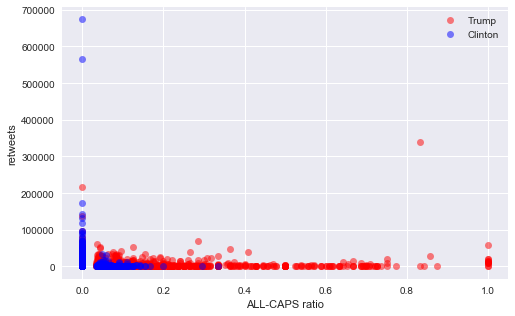

In [13]:
pl.figure(figsize=(8,5))
pl.plot(df[trump].allcaps_ratio, df[trump].retweet_count, 
        'ro', alpha=0.5, label='Trump')
pl.plot(df[clinton].allcaps_ratio, df[clinton].retweet_count, 
        'bo', alpha=0.5, label='Clinton')
pl.legend()
pl.xlabel('ALL-CAPS ratio')
pl.ylabel('retweets')
#pl.show()

The `pandas.scatter_matrix()` plotting function provides a quick way to generate scatter plots of feature pairs.  Shown below is an example for three features, with density plots for each feature shown along the diagonal:

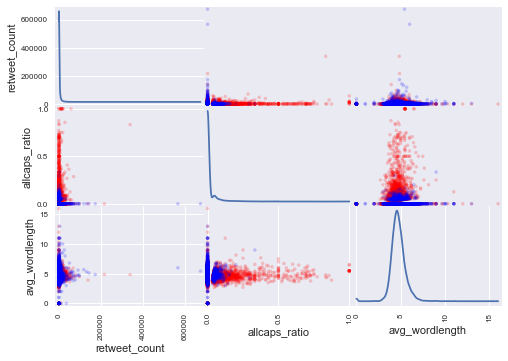

In [15]:
from pandas.plotting import scatter_matrix

pl.figure(figsize=(10,14))
feature_list = ['retweet_count', 'allcaps_ratio', 'avg_wordlength']
colors = ['r']*df[trump].user.count() + ['b']*df[clinton].user.count()
myScatterPlot = scatter_matrix(df[trump].append(df[clinton], ignore_index=True)[feature_list], 
               c=colors, alpha=0.2, diagonal='kde') # diagonal: density plot

In addition to scatter plots for feature pairs, we can compare the Trump and Clinton distributions for each individual feature by generating histograms, separated by color.  For binary classes we'll turn the histograms into bar plots:

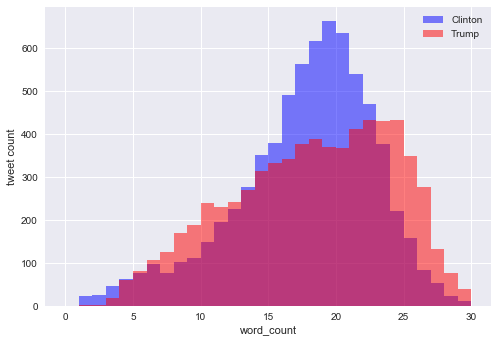

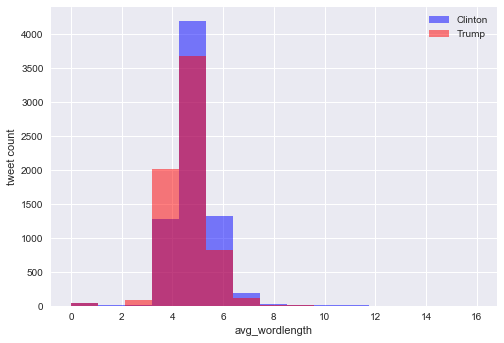

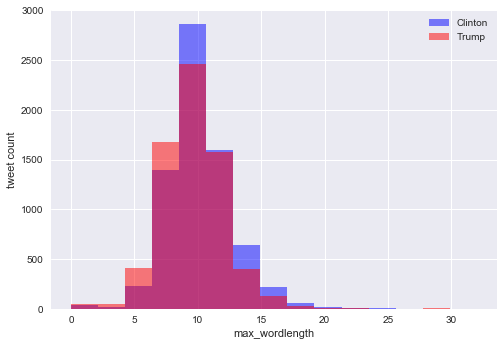

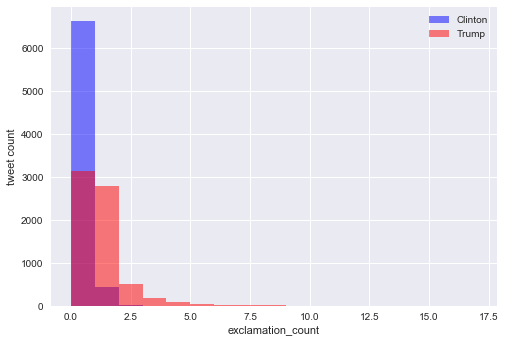

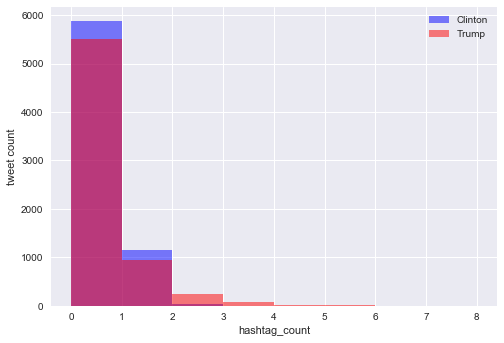

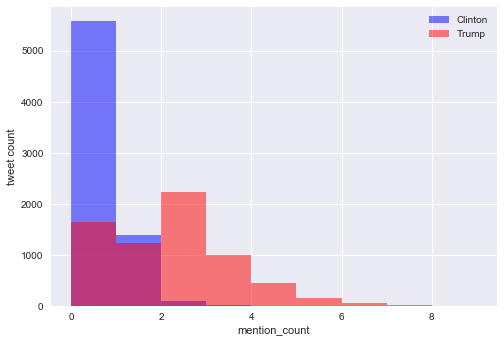

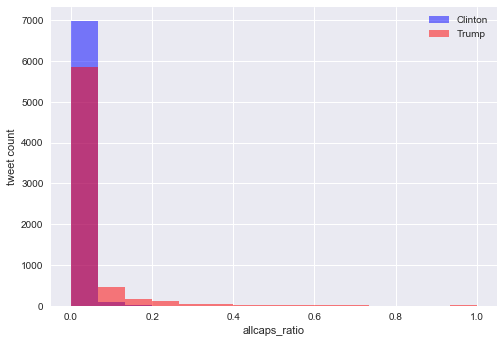

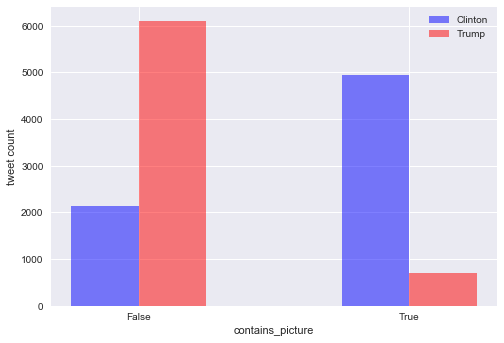

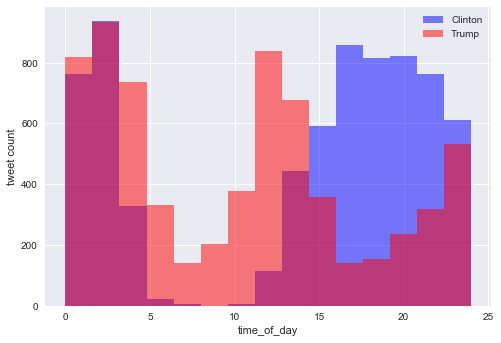

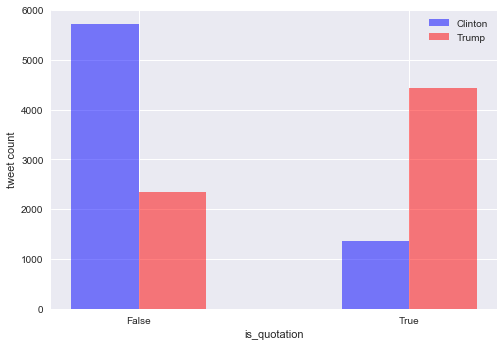

In [16]:
features = ['word_count', 'avg_wordlength', 'max_wordlength', 
            'exclamation_count', 'hashtag_count', 'mention_count', 
            'allcaps_ratio', 'contains_picture', 'time_of_day', 
            'is_quotation']

for feature in features:
    x1, x2 = df[clinton][feature], df[trump][feature]
    
    pl.figure()
    if feature in ['contains_picture', 'is_quotation']:
        # hack to make multi-bar plot
        bins = np.arange(0, 1.75, 0.25)
        x1 = np.concatenate((pl.zeros(sum(x1==False)), pl.ones(sum(x1==True))))
        x2 = np.concatenate((pl.zeros(sum(x2==False)), pl.ones(sum(x2==True)))) + 0.25
        pl.hist(x1, bins=bins, color='b', alpha=0.5, label='Clinton')
        pl.hist(x2, bins=bins, color='r', alpha=0.5, label='Trump')
        pl.xticks([0.25, 1.25], ['False', 'True'])
    else:
        xmin, xmax = min([min(x1), min(x2)]), max([max(x1), max(x2)])
        binwidth = (xmax - xmin)/15.
        bins = np.arange(xmin, xmax+binwidth, binwidth)
        if feature.endswith('count'):
            bins = np.arange(0, xmax+1, 1) 
        pl.hist(x1[~pl.isnan(x1)], bins=bins, color='b', alpha=0.5, label='Clinton')
        pl.hist(x2[~pl.isnan(x2)], bins=bins, color='r', alpha=0.5, label='Trump')
    pl.xlabel(feature)
    pl.ylabel('tweet count')
    pl.legend(loc='best')
    pl.show()

Already we can see that some features will be helpful in themselves to distinguish Trump vs Clinton tweets (e.g., `is_quotation`).  Other features have similar looking distributions for Trump and Clinton, but may still be useful when considered in combination.  

----

# 3. NLP: Identifying the Most Frequent Words

Next we'll write some code to identify the most frequent words and word pairs ("bigrams") in a collection of text strings.  We'll use this code in two ways:

  1. __Exploratory Data Analysis with Tweets:__ identifying the most common words and bigrams in the Clinton and Trump Twitter data sets.  
  2. __Building a Trump Vocabulary List:__ using transcripts of Trump's 2016 campaign stump speeches to form a vocabulary list of his most commonly used words.  This list will be used in parts 5 and 6 to train our SVM and Naive Bayes classifiers.

When counting word frequency we'll ignore everything except for the "word stem"; for example, "crook" and "crooked" share the same stem, "crook."  We'll also exclude so-called "stop words" that are frequent, but not very informative (e.g., "the," "is," "at"). For this purpose we'll use some helpful functions from the Natural Language Processing Toolkit library, `nltk`.

Right now we'll use our code for data exploration.  But it will also be useful later in part 5, where we generate a "vocabulary list" of word stems in Trump's campaign speeches.  

## 3.1 Tokenizing 

We'll work first with an example Trump tweet to illustrate  how the `nltk` functions operate.  (For this illustration I've pre-processed the tweet by removing some extraneous characters -- for example, I chaned "-and" to "and."  We'll automate this with some pre-processing code definedfurther below.)

First we'll "tokenize" the tweet into word tokens.  `nltk.tokenize` includew a helpful `word_tokenize()` function for this purpose.  Unfortunately __`nltk.tokenize` fails to capture twetter metinons ("@-") and hashtags("#"), emoticons, and URLs.__  Although we'll illustrate its use here, __we'll write our own code below that performs better on twiter text.__

In [18]:
from nltk.tokenize import word_tokenize

example_sentence = "Sorry losers and haters, but my IQ \
is one of the highest - and you know it! Please don't feel \
stupid or insecure, it's not your fault"

print word_tokenize(example_sentence)

['Sorry', 'losers', 'and', 'haters', ',', 'but', 'my', 'IQ', 'is', 'one', 'of', 'the', 'highest', '-', 'and', 'you', 'know', 'it', '!', 'Please', 'do', "n't", 'feel', 'stupid', 'or', 'insecure', ',', 'it', "'s", 'not', 'your', 'fault']


Note how the tokenizer helpfully separates the "do" and "n't" ("not") tokens from the contraction "don't," as well as the "it" and "'s" ("is") tokens in "it's."  

## 3.2 Excluding stop words

Next we'll load the `nltk` stop word list.  We'll exclude any word tokens that aren't in the list:

In [19]:
from nltk.corpus import stopwords
print stopwords.words('english')

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [20]:
stop_words = set(stopwords.words('english'))
word_tokens = word_tokenize(example_sentence)

filtered_sentence = [w for w in word_tokens if not w in stop_words]
print(filtered_sentence)

['Sorry', 'losers', 'haters', ',', 'IQ', 'one', 'highest', '-', 'know', '!', 'Please', "n't", 'feel', 'stupid', 'insecure', ',', "'s", 'fault']


## 3.3 Word stemming

We'll use `nltk.PortStemmer` to generate word stems from our tokens:

In [21]:
ps = nltk.PorterStemmer()

word_stems = []
word_tokens = word_tokenize(example_sentence)
for w in word_tokens:
    word_stems.append(ps.stem(w))

print word_stems

[u'sorri', u'loser', 'and', u'hater', ',', 'but', 'my', 'IQ', 'is', 'one', 'of', 'the', 'highest', '-', 'and', 'you', 'know', 'it', '!', u'pleas', 'do', "n't", 'feel', 'stupid', 'or', u'insecur', ',', 'it', "'s", 'not', 'your', 'fault']


There we are: a list of word stems, with stop words excluded.

## 3.4 The NLP pipeline 

We're ready now to put all of these pieces together into an NLP pipeline.  The code below is some robust, social media-tailored NLP code adapted from [Marc Bonzanini's _Mining Twitter Data with Python_](https://marcobonzanini.com/2015/03/02/mining-twitter-data-with-python-part-1/).  It performs the following operations:

  1. __Pre-process__ the text by using the `re` (regular expression) library to identify words, including html tags, twitter mentions, twitter hashtags, etc.; tokenizing the words; and making all non-emoticon words lowercase.
  2. __Exlcude stop words and punctuation.__
  3. __Count the word frequency__ for each word across all tweets using `collection.Counter`.  We'll add the default option to count word frequency based on the total number of times the word appears (counting multiple appearances in a single tweet separately), vs the number of tweets the word appears in.

In [22]:
import string
from collections import Counter

emoticons_str = r"""
    (?:
        [:=;] # Eye characters
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hashtags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with "-", "_" or "'" in the middle
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # any other non-whitespace character
]

# re.VERBOSE to ignore spaces (see the emoticons regex).
# re.IGNORECASE to catch both upper- and lower-case instances.
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def preprocess(tweet, lowercase=True, exclude_single_chars=True):
    '''
    A function to transform the text of an individual tweet into a list
    of tokens.  Tokens include words, emoticons, hashtags, mentions, URLs, 
    or numbers.  
    - Input: tweet = tweet text string
    - Output: tokens = list of tokens
    - Default settings:
        * lowercase=True: non-emoticon text is made lowercase (low) and 
        * exclude_single_chars=True: single-character tokens are excluded 
          from the output list.
    '''
    tokens = tokens_re.findall(tweet)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    if exclude_single_chars:
        tokens = [t for t in tokens if len(t) > 1]
    return tokens

punctuation = list(string.punctuation)
stop = stopwords.words('english') + punctuation + ['rt', 'via'] # 'rt' / 'via' for retweets

def get_word_frequency(tweets, count_once_per_tweet=False):
    '''
    A function to count the frequency of words across a list of tweets,
    excluding stop words.
     - Input:  tweets = list of tweet text strings
     - Output: count_all = collections.Counter container that tracks how  
               many times each word token appears in the tweet text strings.
     - Default settings:
       * count_once_per_tweet=False: separate instances of a token in a single
         tweet are each counted separately.  Set to False to count the numner of
         tweets containing one or more instance of each token.
    '''
    count_all = Counter()
    for tweet in tweets:
        tokens = preprocess(tweet)
        terms_all = [term for term in tokens if term not in stop]
        if count_once_per_tweet:
            terms_all = set(terms_all) 
        count_all.update(terms_all) # update the counter
    return count_all

test_tweet = r'This is a tweet @RealDonaldTrump; the folks at https://onwardtogether.org \
say hi, Big-League. Hi, and hi again! Now parse.these two words. :-)'

print 'TEST TWEET:\n%s\n' % test_tweet
print get_word_frequency([test_tweet])

TEST TWEET:
This is a tweet @RealDonaldTrump; the folks at https://onwardtogether.org say hi, Big-League. Hi, and hi again! Now parse.these two words. :-)

Counter({'hi': 3, 'parse': 1, ':-)': 1, 'https://onwardtogether.org': 1, 'tweet': 1, 'two': 1, 'big-league': 1, '@realdonaldtrump': 1, 'say': 1, 'words': 1, 'folks': 1})


So far so good: we've parsed the test tweet; recognized and counted each word/mention/emoticon/url regarless of upper/lowercase; and excluded stop words like "This," "is," "a," etc.

----

## 3.5 Exploratory data analysis: Clinton and Trump tweets

We're ready to apply our code to the Clinton and Trump data sets.  We'll look first at the 40 most frequent words in the Trump vs the Clinton tweets.  Then we'll look at bigrams (two-word combos).

In [23]:
trump_word_freqs = get_word_frequency(df[trump].text.values)
clinton_word_freqs = get_word_frequency(df[clinton].text.values)

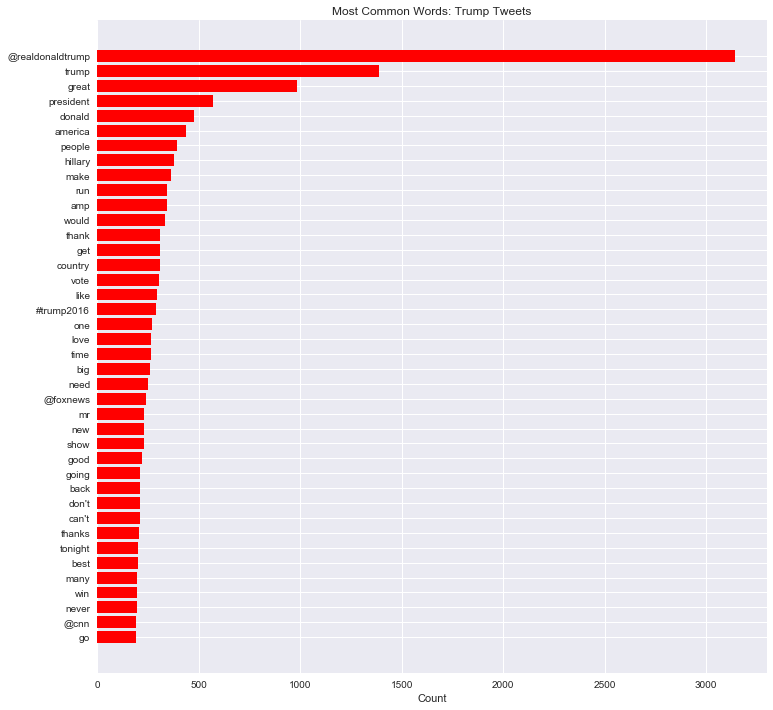

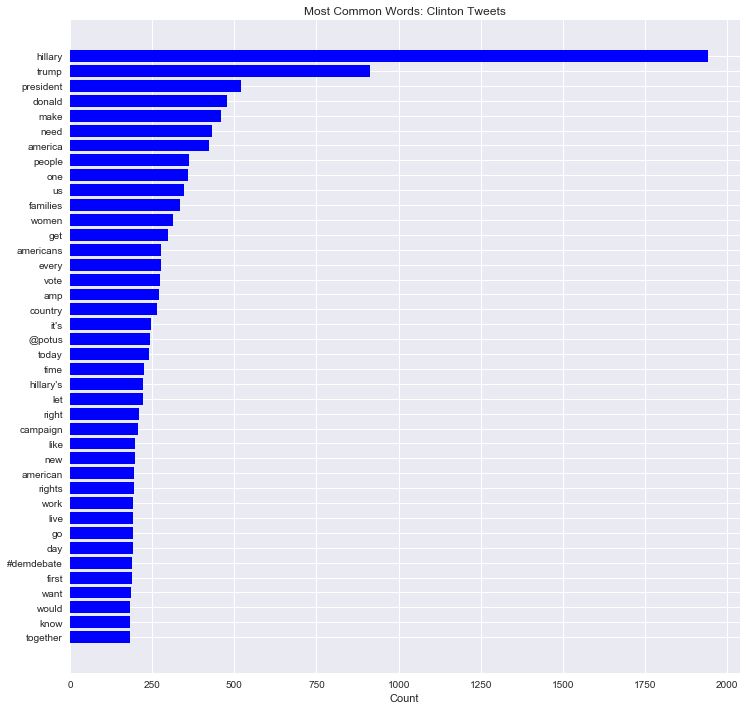

In [24]:
def plot_word_frequency(data, color='k', title='Twitter Word Count'):
    words, counts = zip(*data) 
    val = counts[::-1]   # sort the bars from longest to shortest
    words = words[::-1]
    pos = np.arange(len(data))+.5  # center the bars on the y axis
    
    pl.figure(figsize=(12,12))
    pl.barh(pos, val, align='center', color=color)
    pl.yticks(pos, words)
    pl.xlabel('Count')
    pl.title(title)
    pl.grid(True)
    pl.show()

plot_word_frequency(trump_word_freqs.most_common(40), 'r', 'Most Common Words: Trump Tweets')
plot_word_frequency(clinton_word_freqs.most_common(40), 'b', 'Most Common Words: Clinton Tweets')

So far there are few surprises: Trump's favorite words include "make," "america," "great," "again," and "@foxnews"; Clinton's list includes terms like "families" and "women."  But note that __both Trump and Clinton focused a lot of their tweets on Trump.__
  * Trump's 1st, 2nd, and 5th most used words are references to himself, while Hillary appears at a distant number 8 on his list.  (We can expect that "hillary" would appear higher on the list if we limited ourselves to tweets later in the campaign.)
  * Hillary's most frequent word is "hillary," but her 2nd and 4th most frequent words are "trump" and "donald."  

To look at bigrams we'll use the `nltk.bigrams` function:

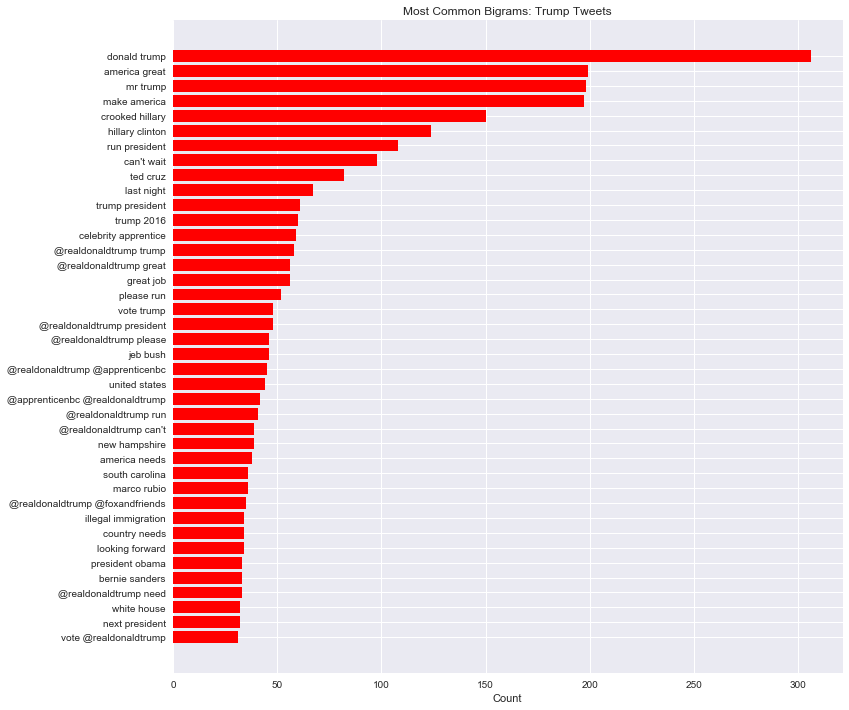

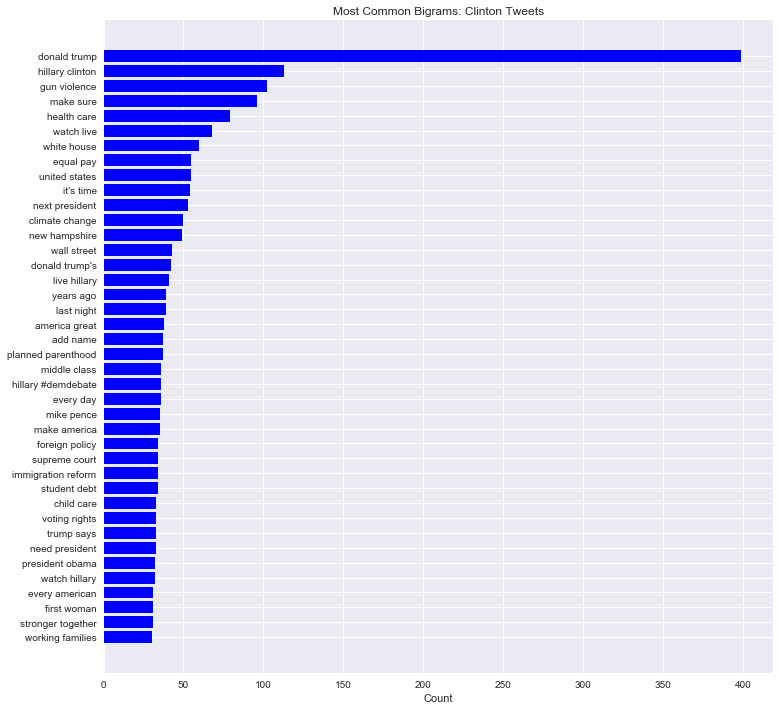

In [25]:
from nltk import bigrams 

def get_bigram_frequency(tweets, count_once_per_tweet=False):
    count_all = Counter()
    for tweet in tweets:
        tokens = preprocess(tweet)
        terms_all = [term for term in tokens if term not in stop]
        terms_bigram = bigrams(terms_all)
        if count_once_per_tweet:
            terms_bigram = set(terms_bigram)
        count_all.update([' '.join(w) for w in terms_bigram])
    return count_all

trump_bigrams = get_bigram_frequency(df[trump].text.values)
clinton_bigrams = get_bigram_frequency(df[clinton].text.values)

plot_word_frequency(trump_bigrams.most_common(40), 'r', 'Most Common Bigrams: Trump Tweets')
plot_word_frequency(clinton_bigrams.most_common(40), 'b', 'Most Common Bigrams: Clinton Tweets')

The bigram counts tell a similar story: 
  * Although Clinton appears 5th and 6th on Trump's list (as "crooked hillary" and "hillary clinton"), his most common bigram by far is "donald trump," with "mr trump" in 3rd place.  Meanwhile, Clinton's most frequent bigram is "donald trump," with "hillary clinton" a distant second. 
  * Note that Clinton's most frequent bigrams include many references to issues of public policy (e.g., "gun violence," "health care," voting rights," "child care"), while Trump's non-self-referential bigrams are aimed mostly at his rivals (Cruz, Bush, Clinton, Sanders); "celebrity apprentice" also makes it into Trump's top-15 list.

## 3. 6 Building a vocabulary list from Trump campaign speeches

In parts 5 and 6 we'll train an SVM to compare tweets against a vocabulary list of Trump's favorite words, the same way a spam classifier compares e-mail text to a vocabulary of words culled from a repository of known spam e-mails.   Here we'll generate a presidential vocabulary list ourselves. 

We might use half of the Trump tweets for this purpose, saving the other half for training and testing the SVM.  But this would cut down on our available data considerably.  Instead we'll assemble a vocabulary list from a collection of Trump's 2016 campaign speeches.  There is some danger here, as a typical person's spoken word frequencies could vary substantially from their written/tweeted word frequencies; but Trump's breezy stump speeches often sound an awful lot like his tweets.  We'll proceed with this caveat in mind and will see how we do.

We'll parse a collection of Donald Trump 2016 presidential campaign speeches to determine Trump's 2500 most frequently used words.  Then we'll generate a "vocabulary list" containing solely the unique "word stems" associated with the words.  (For example, the words "learn," "learns," "learned," and "learning" share a common word stem: "learn.") We'll stem each word from Trump's speeches using `nltk.PortStemmer()`.  Some of the most common words shrae the same word stem.  For example, "crooked" and "crook" share the same stem, "crook".  Our final svocabulary list will contain just under 2000 word stems.

Our vocabulary list is relatively short.  In practice, many text classification algorithms (e.g., spam filters) often use larger vocabulary lists with ~  10,000 to 50,000 words.  But let's see how well we can do with a short vocabulary list.  We can always expand it later.

We'll begin by loading the combined text of Trump 2016 campaign speeches culled from the web:

In [26]:
if 'combined_speeches.txt' not in os.listdir('./trump_speeches'):
    output = ''
    for f in os.listdir('./trump_speeches/speeches'):
        if f.endswith('.txt'):
            with open(os.path.join('./trump_speeches/speeches', f), 'r') as this_file:
                out = this_file.read().replace('\n', ' ')
                output += ' %s' % out
            this_file.close()
    outfile = open('./trump_speeches/combined_speeches.txt', 'w')
    outfile.write(output)
    outfile.close()

speech_text = open('./trump_speeches/combined_speeches.txt', 'r').read()
print 'Trump campaign speeches, first 140 characters:\n\n', speech_text[:140]

Trump campaign speeches, first 140 characters:

 Well, I want to thank everybody.  Very, very special people.  And it is true, this is my first stop, officially.  We’re not talking about


Next we'll call the word frequency and stemming code we presented in part 3 to find the most common 2500 words, then reduce them to their word stems:

In [27]:
trump_speech_word_freqs = get_word_frequency([speech_text])

trump_words = []
for word, count in trump_speech_word_freqs.most_common(2500):
    trump_words.append(word)
print 'Trump\'s 100 most frequent campaign speech words:\n', trump_words[:100]

Trump's 100 most frequent campaign speech words:
['going', 'people', 'know', 'said', 'want', 'great', 'like', 'one', 'get', 'think', 'country', 'right', 'say', 'look', 'go', 'many', 'lot', 'money', 'us', 'make', 'got', 'good', 'way', 'back', 'really', 'much', 'would', 'take', 'even', 'never', 'mean', 'tell', 'see', 'time', 'love', 'win', 'thank', "we're", 'big', 'trump', 'well', 'come', 'thing', 'believe', 'things', 'everybody', 'america', 'years', 'world', 'let', 'jobs', 'ever', 'president', 'deal', "it's", 'trade', 'new', 'something', 'china', 'okay', 'guy', 'need', 'could', 'happen', 'million', 'bad', 'talk', 'states', 'nobody', 'done', 'care', 'wall', 'better', 'every', 'ago', 'actually', 'first', 'oh', 'american', 'hillary', 'united', 'came', 'incredible', 'little', 'work', 'number', 'mexico', "don't", 'give', 'folks', 'put', 'two', 'nice', 'remember', "they're", 'made', 'military', 'job', 'build', 'seen']


In [31]:
trump_wordstems = []
for word in trump_words:
    stem = nltk.PorterStemmer().stem(word) 
    if len(stem) < 1: # skip empty strings
        continue
    if stem not in trump_wordstems:
        trump_wordstems.append(stem)

print len(trump_wordstems)
print trump_wordstems[:100]

1912
[u'go', u'peopl', 'know', 'said', 'want', 'great', 'like', 'one', 'get', 'think', u'countri', 'right', 'say', 'look', u'mani', 'lot', 'money', 'us', 'make', 'got', 'good', 'way', 'back', u'realli', 'much', 'would', 'take', 'even', 'never', 'mean', 'tell', 'see', 'time', 'love', 'win', 'thank', u"we'r", 'big', 'trump', 'well', 'come', 'thing', u'believ', u'everybodi', 'america', u'year', 'world', 'let', u'job', 'ever', u'presid', 'deal', u"it'", 'trade', 'new', u'someth', 'china', 'okay', 'guy', 'need', 'could', 'happen', 'million', 'bad', 'talk', u'state', u'nobodi', 'done', 'care', 'wall', 'better', u'everi', 'ago', u'actual', 'first', 'oh', 'american', u'hillari', u'unit', 'came', u'incred', u'littl', 'work', 'number', 'mexico', "don't", 'give', u'folk', 'put', 'two', 'nice', u'rememb', u"they'r", 'made', u'militari', 'build', 'seen', 'also', 'bring', u'somebodi']


Now that we have our word stem vocabilary list, we'll write it to file now safekeeping and easy loading later:

In [32]:
filename = 'presidential_vocabulary_essence.txt'
if filename not in os.listdir('.'):
    outfile = open(filename, 'w')
    for i, w in enumerate(trump_wordstems):
        outfile.write('%s %s\n' % ((i+1), w))
    outfile.close()


----
# 4. Sentiment Analysis (Sad!)

Next we'll add a `sentiment` score to the data frame, indicating the emotional valence of each tweet.

## 4.1 VADER analysis with `nltk.sentiment`

The `ntlk` library includes a powerful, easy-to-use sentiment analysis tool called the [Valence Aware Dictionary and sEntiment Reasoner (VADER)](http://www.nltk.org/_modules/nltk/sentiment/vader.html).  VADER includes several features to facilitate sentiment analysis of social media text, including recognition of emoticons, capitalization ("good" vs "GOOD"), and sensitivity to the presence of modifying words (e.g., "bad" vs "extremely bad"). See [here](http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html) for an informative reveiw.

When called on an input text, the VADER analyzer returns three values indicating the level of positive, and negative, and neutral sentiment in the text (each from 0 to 1), as well as a compound sentiment value (from -1 to +1) that indicates the overall sentiment polarity.  We'll assign compound sentiment values to each tweet in our data frame.  

First let's test it out on some example Trump tweets:

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

def analyze_sentiment_vader(text, neg_cutoff=-0.3, 
                            pos_cutoff=0.3):
    '''
    Vader sentiment intensity analyzer: 
    - Input: text = tweet text
    - Output: 
      * score = VADER compound aggregate score, ranging from -1 (negative valence) 
        to +1 (positive valence). 
      * sentiment_label = 'positive', 'negative,' or 'neutral' based on whether 
        the score is below (above) the cutoff value neg_cutoff (pos_cutoff).  
        By default neg_cutoff = -0.3 and pos_cutoff = +0.3.
    '''
    score = sia.polarity_scores(text)['compound']
    if score < neg_cutoff:
        sentiment = 'negative'
    elif score > pos_cutoff:
        sentiment = 'positive'
    else:
        sentiment = 'neutral'
    return sentiment, score

print example_sentence
analyze_sentiment_vader(example_sentence)

Sorry losers and haters, but my IQ is one of the highest - and you know it! Please don't feel stupid or insecure, it's not your fault


('positive', 0.3905)

Already we see that sentiment analysis has its limits.  It can be tricky to assign polarities to sarcastic statements like the one above, although I suppose the sentence is positive with respect to Trump.

Let's try a few more:

In [35]:
strings = []

strings.append('mention crime infested) rather than falsely complaining about the election results. \
All talk, talk, talk - no action or results. Sad!')

strings.append("I have a judge in the Trump University civil case, \
Gonzalo Curiel (San Diego), who is very unfair. An Obama pick. Totally biased-hates Trump")

strings.append("Thank you Arizona! #VoteTrump https://t.co/v8VLxdd0fO")

strings.append("By not doing the failed, poorly rated debate, I was able \
to make the point of not allowing \"unfairness\" - while raising $6,000,000 for VETS.")

strings.append("Departing New York with General James 'Mad Dog' Mattis for tonight's \
rally in Fayetteville, North Carolina! See you… https://t.co/Z8sgJBWI09")

for s in strings:
    print '\n', s
    print analyze_sentiment_vader(s)


mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!
('negative', -0.8718)

I have a judge in the Trump University civil case, Gonzalo Curiel (San Diego), who is very unfair. An Obama pick. Totally biased-hates Trump
('negative', -0.5256)

Thank you Arizona! #VoteTrump https://t.co/v8VLxdd0fO
('positive', 0.4199)

By not doing the failed, poorly rated debate, I was able to make the point of not allowing "unfairness" - while raising $6,000,000 for VETS.
('positive', 0.4023)

Departing New York with General James 'Mad Dog' Mattis for tonight's rally in Fayetteville, North Carolina! See you… https://t.co/Z8sgJBWI09
('negative', -0.5411)


The analyzer performs well on the first three, but poorly on the final sentence (perhaps being fooled by the phrase "Mad Dog.")  One can argue that the fourth sentence is arguably misclassified; although it ends on a positive, boastful note, it begins with some negative sniping.

Nonetheless we'll apply the analyzer to the tweets, with the recognition that its performance is far from perfect:

In [36]:
def get_sentiment_score(text):
    return analyze_sentiment_vader(text)[1]

df['sentiment'] = df['text'].apply(get_sentiment_score)
df.head()

,created_at,favorite_count,id_str,in_reply_to_screen_name,is_retweet,retweet_count,source,text,user,word_count,...,max_wordlength,longest_word,exclamation_count,hashtag_count,mention_count,allcaps_ratio,contains_picture,time_of_day,is_quotation,sentiment
0,2013-05-20 10:09:49,24,336423508580118528,None,False,25,Twitter for Android,"""@j_cohl: I'm kinda hoping that @realDonaldTru...",Trump,20,...,9,President,0,0,3,0.050000,False,10.150000,True,0.7383
1,2013-03-29 18:10:03,174,317700194269552640,None,False,287,Twitter Web Client,Have a great Good Friday and a Happy Easter.,Trump,9,...,7,Easter.,0,0,0,0.000000,False,18.166667,False,0.8934
2,2013-07-13 00:02:07,4,355839520194838528,None,False,5,Twitter for Android,"""@JewelsInLotus: @realDonaldTrump @BG9half @Th...",Trump,8,...,9,Beautiful,3,0,4,0.000000,False,0.033333,True,0.9095
3,2017-01-14 13:07:12,77031,820255947956383744,None,False,16606,Twitter for Android,mention crime infested) rather than falsely co...,Trump,20,...,11,complaining,1,0,0,0.000000,False,13.116667,False,-0.8718
4,2014-11-24 21:38:39,1387,536997346585096192,None,False,1296,Twitter Web Client,ISIS is starting its own currency. May be stro...,Trump,17,...,12,implemented.,0,0,0,0.058824,False,21.633333,False,0.3818


## 4.2 Results

A histogram of the sentiment polarities shows that they are __similar on the whole between the two candidates.  But they may still be helpful__ if the combination of sentiment and other feature(s) tends to distinguish between the candidates (for example, if early-morning tweets with negative sentiment tend to come from Trump).  We'll keep the sentiment feature in our data frame for now.

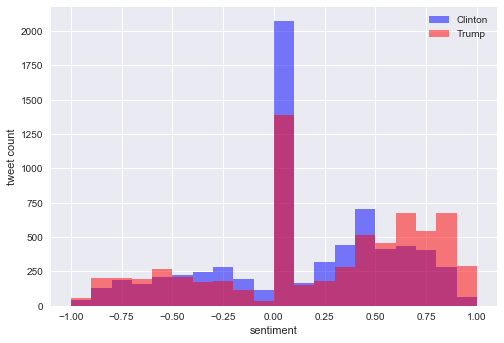

In [37]:
pl.figure()
bins = np.arange(-1,1.1,0.1)
pl.hist(df[clinton].sentiment, bins=bins, color='b', alpha=0.5, label='Clinton')
pl.hist(df[trump].sentiment, bins=bins, color='r', alpha=0.5, label='Trump')
pl.xlabel('sentiment')
pl.ylabel('tweet count')
pl.legend()
pl.show()

As a sanity check and for amusement, __let's view the tweets from each candidate that were rated the most positive and negative:__

In [38]:
def print_tweets_by_sentiment(df, num_tweets=3, sentiment='negative'): # negative or positive
    ascending = False
    if sentiment == 'negative':
        ascending = True
    users = list(set(df['user'].values))
    if len(users) == 1:
        users = users[0]
    if sentiment == 'neutral':
        subset = df.reindex(df.sentiment.abs().sort(inplace=False).index).reset_index()
    else:
        subset = df.sort_values(by='sentiment', ascending=ascending).reset_index()
    print ('\n\n%s MOST %s %s TWEETS:' % (num_tweets, sentiment, users)).upper()
    for i in range(num_tweets):
        print '\n', subset['text'][i]
        print 'sentiment:', subset['sentiment'][i]

print_tweets_by_sentiment(df[trump], sentiment='negative')
print_tweets_by_sentiment(df[trump], sentiment='positive')



3 MOST NEGATIVE TRUMP TWEETS:

I love the Mexican people, but Mexico is not our friend. They're killing us at the border and they're killing us on jobs and trade. FIGHT!
sentiment: -0.9676

General John Allen, who I never met but spoke against me last night, failed badly in his fight against ISIS. His record = BAD  #NeverHillary
sentiment: -0.9631

We must stop the crime and killing machine that is illegal immigration. Rampant problems will only get worse. Take back our country!
sentiment: -0.9628


3 MOST POSITIVE TRUMP TWEETS:

"@Joe_Hurwitz: @realDonaldTrump WOW YOU ARE GREAT AND YOUR HAIR IS AWESOME"  Wow, I love the second part!
sentiment: 0.9764

Governor John Kasich of the GREAT, GREAT, GREAT State of Ohio called to congratulate me on the win. The people of Ohio were incredible!
sentiment: 0.9744

"@PaulaDuvall2: We're all enjoying you, as well, Mr. T.! You've inspired Hope and a Positive Spirit throughout America! God bless you!" Nice
sentiment: 0.9735


In [39]:
print_tweets_by_sentiment(df[clinton], sentiment='positive')
print_tweets_by_sentiment(df[clinton], sentiment='negative')



3 MOST POSITIVE CLINTON TWEETS:

At our best, America has united behind the ideal that everyone deserves a fair shot. At its best, the Supreme Court has defended that ideal.
sentiment: 0.9747

.@VP is a good friend and a great man. Today and always, inspired by his optimism and commitment to change the world for the better. -H
sentiment: 0.9698

Happy Fourth of July! Today let's celebrate the best of America—our freedom, diversity, and the values we share. -H https://t.co/C6Mdt4iVg5
sentiment: 0.9682


3 MOST NEGATIVE CLINTON TWEETS:

We need commonsense reforms to keep weapons out of the hands of criminals, the violently unstable, domestic abusers, and terrorists.
sentiment: -0.9666

My prayers are with the victims of the horrific Easter Day attack in Lahore. Pakistan and all nations must confront &amp; defeat terrorists. -H
sentiment: -0.9559

Gun violence and hate aren't isolated—homophobia in Orlando, racism in Charleston. We need to fight them together. https://t.co/HcBJzknBz7
s

----
# 5. The SVM Classifier: Vocabulary List Features Only

## 5.1 The _ABCs_ of SVMs

__Overview:__ [Support vector machines (SVMs)](https://en.wikipedia.org/wiki/Support_vector_machine) are supervised learning models that are often useful for binary classification.  They look for the __decision boundary__ that "best" separates the training data classes, i.e., __the hyperplane that maximizes the "margin": the distance to the nearest point in each class.__   

The 2-dimensional examples shown below are plots I made for [Andrew Ng's Coursera machine learning class](https://www.coursera.org/learn/machine-learning), which I completed while finishing my Ph.D.  (The class was taught in Octave.  I translated all of the assignments into Python, and used the `sklearn` library for these examples.)  

In each plot, each training example comes with a __label__ specifying whether it is a positive or negative sample (i.e., whether it does/does not belong to the class), as well as values for two __features__ plotted on the $x$ and $y$ axes (Variable 1 and Variable 2).  

__Kernels:__  The samples are used to train an SVM with a specified __kernel__, ultimately yielding the decision boundaries shown in the plots.
 * __Linear Kernel:__ In the left plot, the data are linearly separable.  In this case we train the SVM using a _linear kernel_, yielding the hyperplane that best separates the positive and negative samlpes.  In the 2D case the hyperplane is a line.
 * __Gaussian Kernel:__  In the right plot, there is no line that cleanly separates the samples.  But we can find a curved hypersurface that separates the data fairly well.  This is achieved by training the SMV with a _Gaussian kernel_  -- in this case, the [Radial Basis Function (RBF) kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel).  (Non-linear kernels like RBF work by applying a _kernel function_ to transform the data into a higher dimensional space, where they can be more cleanly separated by hyperplanes.  For more details [see here](https://en.wikipedia.org/wiki/Support_vector_machine#Kernel_trick).)
 * Non-linear kernels like the RBF kernel generally perform better, but they are computationally expensive.  For large data sets (tens of thousands of samples or more), a linear kernel is typically used.

|  2D SVM example: linear kernel  |  2D SVM example: Gaussian kernel (RBF)  |
| - | - |
|![alt](ex6plot1.png) | ![alt](ex6plot2.png)|

__SVM vs Logistic Regression:__ SVMs function similarly to [logistic regression (LR) models](https://en.wikipedia.org/wiki/Logistic_regression), but with some important differences:
  1. LR seeks to maximize the probability that data are classified correctly, which increases the farther the data points are from the decision boundary. By contrast [SVMs seek to maximize the distance between the decision boundary and _the points closest to the margin_ (the "support vectors")](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-867-machine-learning-fall-2006/lecture-notes/lec3.pdf).  Points that aren't support vectors don’t matter.
  2. To give greater computational efficiency, the SVM's cost function is a piecewise linear version of the LR cost function (see below right).  
  3. In SVMs, the cost function is multiplied by a __penalty parameter, $C$,__ which controls the penalty cost for misclassified training examples.  Specifying a large $C$ tells the SVM to try to classify all training examples correctly, trading off margin size for accuracy.  $C$ is therefore analogous to the _inverse_ of the regularization parameter $\lambda$ used in LR: $C~\sim~1/\lambda$. 
    * Assigning a large penalty paramter can result in cases like the plot below on the left (again from my Coursera class).  The outlier positive sample on the far left side results in a decision boundary that classifies the samples correctly, but provides an "unnatural" separation; the decision boundary skirts perilously close to the class samples.  A line passing straight through the middle of the gap (margin) between the two classes misclassifies the outlier sample, but would most likely perform better on new samples.
    * With a smaller penalty parameter the SVM trades off accuracy for increased margin size.  In the above left plot, it _misclassifies the outlier point, but provides the more "natural" looking boundary_ between the classes.  Although that boundary misclassifies one point, it is likely to perform better on new samples than the perfect-but-unnatural LR boundary.
    * To determine the optimum $C$ value, we'll use a cross-validation set to find the misclassification error for a range of $C$ values (see part 5.6).

|  SVM, large $C$: 100% accurate, "unnatural" boundary  |  Example LR and SVM cost functions  |
| - | - |
|![alt](ex6unnatural.png) | ![alt](svm_lr_cost_fcn.png)|



----

## 5.2 Our SVM: An Overview

In this part __we will train a linear SVM classifier to accurately separate Trump tweets (positive samples) from Clinton tweets (negative samples) based solely on the word content of the tweets.__  For now we'll ignore the "new features" we explored in part 2.  In part 6 we'll add those features as well to see if they improve our predictive ability.

Our approach will adapt an e-mail spam filter I created as an assignment in [Andrew Ng's ML class](https://www.coursera.org/learn/machine-learning).  In that assignment we compared the words in sample e-mails to a pre-supplied vocabulary list assembled from the most common words in a repository of known spam e-mails.  The SVM used matches between word stems in the e-mail sample and word stems on the spam vocabulary list to categorize the e-mail as spam or ham (not-spam).  We will use a similar approach here, with spam = Trump and non-spam = Clinton.  

__We'll have to generate our own analogous "vocabulary list" of Trump's favorite words.__  We might use half of the Trump tweets for this purpose, saving the other half for training and testing the SVM.  But this would cut down on our available data considerably.  Instead we'll assemble a vocabulary list from a collection of Trump's 2016 campaign speeches.  There is some danger here, as a typical person's spoken word frequencies could vary substantially from their written/tweeted word frequencies; but Trump's breezy stump speeches often sound an awful lot like his tweets.  We'll proceed with this caveat in mind and will see how we do.

__Procedural Outline:__ In the remainder of this section we will:

  1. __Load the Vocabulary List:__ Load the list of most-commonly-used word stems culled from Trump 2016 campaign speeches, which we generated in part 3.
  2. __Pre-process and tokenize each tweet:__ Pre-process each tweet by separating the text into words, stripping unwanted characters, and removing everything except for the "word stem." Obtain the set of word stems that appear on the vocabulary list, ignoring all other word stems.
  4. __Generate feature vectors:__ Transform the word tokens into binary feature vectors to make them usable by the SVM.  A tweet's feature vector contains a '1' or a '0' at each vector element, indicating the presence or absence of a specific word stem from the vocabuilary list.
  5. __Separate the Data into Trainig/CV/Test Sets:__ Randomly subdivide the data into the three subsets: training  (60%), cross-validation (20%), and test sets (20%).
  6. __Run the SVM on the Training and CV Sets; Choose Optimum $C$:__ For a range of $C$ penalty parameter values, initialize an SVM and train it on both the training set and on the cross-validation set, keeping track of the total misclassification cost at each step.  As explained below, this allows us to determine an optimal $C$ value.
  7. __Run the Optimized SVM on the Test Set:__ Use the optimal $C$ value to initialize and optimal SVM; apply the SVM to the test set to measure its performance.

OK Computer . . .

In [40]:
def get_vocab_list():
    # loads the vocabulary list of Trump's favorite word stems created in Part 3 above
    vocab = {}
    for line in open('presidential_vocabulary_essence.txt').readlines():
        index, word = line.split()
        vocab[word] = int(index)
    return vocab

vocab_list = get_vocab_list()

## 5.3 Generating feature vectors

We'll now use our vocabulary list to generate a feature vector for each tweet's text.  For each tweet we will construct a 1912-element feature vector, with a '1' or a '0' indicating the presence/absence of each word stem in the  vocabary list.

First we'll tokenize the text by obtaining the index for each word stem in the tweet that appears on the vocabulary list.  We'll first run our code on a test tweet to view the input text, the word stems, and the number tokens corresponding to the text.

In [42]:
def tokenize_text(tweet_text, vocab_list, verbose=False):
    '''
    A function to transform the text of a tweet into a list of 
    indices corresponding to word stems in a vocabulary list of 
    representative word stems culled from Trump campaign speeches.
    - Inputs: 
      * tweet_text (string) = text contents of a single tweet
      * vocab_list = indexed list of the most common word stems
        in Trump campaign speeches, where the j-th most common word 
        stem is assigned index j.
    - Output: word_indices = sorted list of vocab_list indices corresponding
              to word stems that appear in the tweet_text.
    '''
    if verbose:
        print 'INPUT:\n%s\n' % tweet_text
    word_indices = []
    contents = copy.copy(tweet_text)
    contents = contents.lower()
    words = re.findall(r"[\w']+", contents)
    for word in words: 
        word = re.sub(r'[^a-zA-Z0-9]', r'', word) # remove non-alphanumeric
        word = nltk.PorterStemmer().stem(word) 
        if len(word) < 1: # skip empty strings
            continue
        if word in vocab_list.keys():
            word_indices.append(vocab_list[word])
    word_indices = list(set(word_indices))
    if verbose:
        vocab_words = [w for w in vocab_list.keys() if 
                      vocab_list[w] in word_indices]
        print 'VOCAB LIST INDICES, WORD STEMS:\n%s\n%s' % \
                (word_indices, vocab_words)
    return sorted(word_indices)

# Test on a single Trump tweet:
test_tweet = df[trump].text.values[0]
word_indices = tokenize_text(test_tweet, vocab_list, verbose=True)

INPUT:
mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!

VOCAB LIST INDICES, WORD STEMS:
[65, 458, 459, 558, 271, 402, 851, 847, 540]
['fals', 'result', 'elect', 'talk', 'sad', 'crime', 'action', 'rather', 'mention']


Next we'll convert each tweet's token list into an $n$-dimensional vector, where $n$ is the number of words in the vocabulary list. Specifically, the element $x_i$ of the feature vector will be set to {$0,~1$} for a tweet if the $i$-th word in the vocab list {is not, is} in the tweet.

In [43]:
def get_feature_vector(word_indices, vocab_list):
    '''
    A function to generate a feature vector from a list of
    vocabulary list indices corresponding to word stems found
    in a tweet.
    - Input: 
      * word_indices = list of vocabulary list indices corresponding
        to word stems that appear in a single tweet
      * vocab_list = indexed list of the most common word stems in Trump 
        campaign speeches, where the j-th most common word stem is assigned 
        index j.
    - Output: features = column vector of word stem features, with the j-th
      element set to 0 (1) if th j-th word in the vocab list is not (is) in the 
      word_indices list
    '''
    features = pl.zeros((len(vocab_list.keys()), 1))
    for index in word_indices:
        features[index] = 1
    return features

test_tweet_features = get_feature_vector(word_indices, vocab_list)
print 'Number of vocab list word stems:', int(np.sum(test_tweet_features))

Number of vocab list word stems: 9


## 5.4 Dividing the data into Training, Testing, and Cross-Validation sets

Next we'll divide the tweets into 3 subsets, following the common rule-of-thumb 60-20-20 split:
 * 60% training data
 * 20% cross-validation data
 * 20% test data

We'l do this by:
  1. Creating a random permutation of the data frame row indices.  
   * We do this by randomly sampling `num_rows` samples (without replacement) from `range(num_rows)`, using the `random.selection()` function.  
   * To enable replicability we'll set the seed of our pseudo-random number generator using `random.seed()`.  
   * We'll store the array of randomized row indices as `randomized_idxs`.
  2. Slicing the array of randomized row indices, assigning the first 60% to our training set; the next 20% to the cross-validation set; and the final 20% to the training set.

A quick check shows that our combined data set -- consisting of all Trump tweets from Trump's Android phone and all Clinton tweets (regardless of source) sent on or after Jan. 1, 2015 -- is divided roughly evenly between Trump and Clinton tweets:

In [44]:
num_trump = len(df[trump].text.values)
num_clinton = len(df[clinton].text.values)
num_total = num_trump + num_clinton

print 'Trump tweets:\t%s (%.1f%% of total)' % (num_trump, 100. * \
                                             float(num_trump)/num_total)
print 'Clinton tweets:\t%s (%.1f%% of total)' % (num_clinton, 100. * \
                                               float(num_clinton)/num_total)

data = df[trump | clinton] # excludes pre-2015-01-01 / non-Android Trump tweets
print 'Total tweets:\t', len(data.text.values) # sanity check

Trump tweets:	6795 (49.0% of total)
Clinton tweets:	7082 (51.0% of total)
Total tweets:	13877


Now we'll randomize the row indices and divide them 60-20-20 among the training, cross-validation, and test sets:

In [45]:
import random

# Sample the row indices, without replacement:
num_rows = len(data.text.values)
random.seed(123)
randomized_idxs = random.sample(range(num_rows), num_rows)

# Define the number of samples in each set (60%-20%-20%):
num_training_samples = int(num_rows * 0.6)
num_cv_samples = int(num_rows * 0.2)
num_test_samples = num_rows - num_training_samples - num_cv_samples

# Slice the randomized row indices:
train_idxs = randomized_idxs[:num_training_samples]
cv_idxs = randomized_idxs[num_training_samples:num_training_samples + num_cv_samples]
test_idxs = randomized_idxs[num_training_samples + num_cv_samples:num_rows]

print 'num training samples:\t%s' % len(train_idxs)
print 'num cross-val samples:\t%s' % len(cv_idxs)
print 'num test samples:\t%s' % len(test_idxs)

num training samples:	8326
num cross-val samples:	2775
num test samples:	2776


In [46]:
for idxs, setname in zip([train_idxs, cv_idxs, test_idxs], 
                         ['Training', 'Cross-validation', 'Test']):
    num_trump = sum(data.user.values[idxs] == 'Trump')
    num_clinton = sum(data.user.values[idxs] == 'Clinton')
    total = num_trump + num_clinton

    pct_trump = 100. * num_trump/total
    pct_clinton = 100. * num_clinton/total
    
    print '\n%s set:' % setname
    print 'Clinton:\t%s tweets (%.1f%%)' % (num_clinton, pct_clinton)
    print 'Trump:\t\t%s tweets (%.1f%%)' % (num_trump, pct_trump)


Training set:
Clinton:	4269 tweets (51.3%)
Trump:		4057 tweets (48.7%)

Cross-validation set:
Clinton:	1405 tweets (50.6%)
Trump:		1370 tweets (49.4%)

Test set:
Clinton:	1408 tweets (50.7%)
Trump:		1368 tweets (49.3%)


## 5.5 Forming the feature matrix `X` and label vector `y`

First we'll define a `generate_feature_vector()` function to create a feature vector from the text of a given tweet.    
  * The feature vector consists of a column vector of 1s and 0s, where a 1 (0) at position $i$ indicates the presence (absence) of _one or more_ words that correspond to word stem $i$ in our vocabulary list.  For example, a tweet containing the text "Crooked Hillary is a crook!" contains _two_ instances of the word stem "crook"; its feature vector would therefore contain a "1" at position 812, since item 812 in the vocabulary list is the word stem "crook".
  * Recall that the vocabulary list contains the word stems of the most frequently used words in Trump's campaign speeches, in order of most- to least-frequent.
  * Each feature vector therefore contains $n$ elements, where $n$ is the number of word stems in the vocabulary list ($n$ = 1912 word stems).
  * We'll apply the function to a test tweet.  The sum of the 1s in the tweet's feature vector indicates the number of word stems in our vocabulary list that are present in the tweet.

Next we will: 
 * Stack the feature vectors for each tweet horizontally, producing a feature matrix __`X`__ that we'll use to train our SVM.  
 * Generate an $n$-dimensional "label vector" __`y`__ that indicates whether a each tweet was written by Trump (`y`=1) or by Clinton (`y`=0).

This process will be applied separately to the training, cross-validation, and test sets of tweets, producing three `X`, `y` sets: 

  `{ (X_train, y_train), (X_cv, y_cv), (X_test, y_test) }`

In [47]:
# Define the feature vector-generating function
def generate_feature_vector(tweet, vocab_list):
    word_indices = tokenize_text(tweet, vocab_list)
    features = get_feature_vector(word_indices, vocab_list)
    return features

# apply it to a test tweet:
test_tweet = df[trump].text.values[0]
test_tweet_features = generate_feature_vector(test_tweet, vocab_list)

print 'Test tweet:\n%s\n' % test_tweet
print 'Test tweet features:\n%s' % test_tweet_features
print '\nNumber of vocab list word stems: %i' % test_tweet_features.sum()

Test tweet:
mention crime infested) rather than falsely complaining about the election results. All talk, talk, talk - no action or results. Sad!

Test tweet features:
[[ 0.]
 [ 0.]
 [ 0.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]

Number of vocab list word stems: 9


In [48]:
def get_feature_matrix_and_label_vector(df, vocab_list, randomized_idxs_slice,
                                        use_extended_features=False):
    '''
    A function to generate the feature matrix X and label vector y by
    calling a feature generating function on a randomized set of rows in
    df, specified by randomized_idxs_slice.  The function is called 
    separately to generate X and y for the test, cross-validation, or
    training set. randomized_idxs_slice should be specified to divide the 
    data into 60% (training), 20% (cross-validation), and 20% (test) subsets.
    Input:
     - df: data frame containing the tweets and feature values
     - vocab_list: ordered list of word stems culled from Trump speeches
     - randomized_idxs_slice: the subset of randomized row indices from df 
       to use when generating (X,y) for the training/cross-validation/test set. 
     - use_extended_features: option to include features defined in 
       generate_extended_feature_vector() in addition to vocab_list features.
    Output: 
     - feature matrix X and label vector y, generated from the rows 
       corresponding to randomized_idxs[slice_start_index:slice_end_index].
    '''                                       
    X_vectors, y_labels = [], []
    for idx in randomized_idxs_slice:
        if use_extended_features:
            features = get_extended_feature_vector(df, idx, vocab_list)
        else:
            tweet = df.text.values[idx]
            features = generate_feature_vector(tweet, vocab_list)
        X_vectors.append(features)
        if df.user.values[idx] == 'Trump':
            y_labels.append(1)
        else:
            y_labels.append(0)
    X = np.concatenate(X_vectors, axis=1).T
    y = np.array([y_labels]).T
    return X, y

In [49]:
X_train, y_train = \
    get_feature_matrix_and_label_vector(data, vocab_list, train_idxs)
print 'Traning set: X.shape = %s, y.shape = %s' % (X_train.shape, y_train.shape)
        
X_cv, y_cv = \
    get_feature_matrix_and_label_vector(data, vocab_list, cv_idxs)
print 'CV set: X.shape = %s, y.shape = %s' % (X_cv.shape, y_cv.shape)

X_test, y_test = \
    get_feature_matrix_and_label_vector(data, vocab_list, test_idxs)
print 'Test set: X.shape = %s, y.shape = %s' % (X_test.shape, y_test.shape)

Traning set: X.shape = (8326, 1912), y.shape = (8326, 1)
CV set: X.shape = (2775, 1912), y.shape = (2775, 1)
Test set: X.shape = (2776, 1912), y.shape = (2776, 1)


## 5.6 Training the SVM; selecting the penalty parameter _C_

We're finally ready to train a linear SVM to predict whether a tweet comes from Donald Trump.  We'll use the training set to train our SVM for a range of _penalty parameters_, $C$.  Then we'll apply each SVM to our cross-validation set to determine the optimal value of $C$ to use for our test set. 

[__Note: a complete analysis would a variety of $k$-fold cross-validaiton__ to ensure that our selected $C$-value wasn't impacted by the training/cv/test set partition we happened to use.  See, e.g., [`sklearn.model_selection.KFold`](http://scikit-learn.org/stable/modules/cross_validation.html).  For now we'll use the single randomized training/cv/testing set partition we obtained above.]

The penalty parameter $C$ is similar to 1/$\lambda$, where $\lambda$ is the penalty parameter in regularized regression; it sets the regularization parameter for the model.  Note that there is a tradeoff between bias and accuracy: 
 - Large $C$ $\rightarrow$ lower bias, but high variance
 - Small $C$ $\rightarrow$ higher bias, but lower variance

This portion of the code will take some time to run, as we're fitting 3 data sets using 6 different $C$ values.  Let's set it running in the background, brew some coffee, watch an episode of _The Apprentice_, then come back to check on it.

In [50]:
Cs = [1e-4, 1e-3, 1e-2, 0.1, 1., 10.]
errors_cv, errors_train = [], []

for C in Cs: # store the cross-validation and training set error for each C value
    linear_svm = svm.SVC(C=C, kernel='linear') # create an SVM for this C
    linear_svm.fit(X_train, y_train.flatten()) # Train the SVM

    cv_predictions = linear_svm.predict(X_cv).reshape((y_cv.shape[0],1))
    cv_error = float(sum(cv_predictions != y_cv))/y_cv.shape[0] * 100.
    errors_cv.append(cv_error)

    train_predictions = linear_svm.predict(X_train).reshape((y_train.shape[0],1))
    training_error = float(sum(train_predictions != y_train))/y_train.shape[0] * 100.
    errors_train.append(training_error)

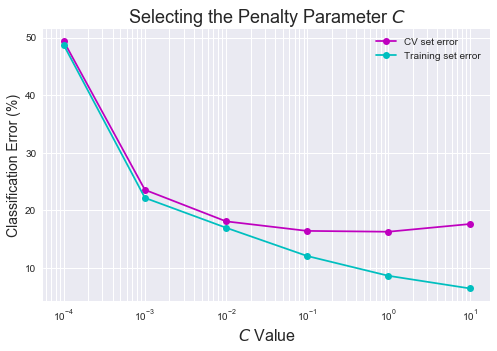

In [51]:
def plot_errors_vs_C(Cs, errors_cv, errors_train):
    pl.figure(figsize=(8,5))
    pl.plot(Cs, errors_cv,'mo-',label='CV set error')
    pl.plot(Cs, errors_train,'co-',label='Training set error')
    pl.grid(True, 'both')
    pl.xlabel('$C$ Value',fontsize=16)
    pl.ylabel('Classification Error (%)',fontsize=14)
    pl.title('Selecting the Penalty Parameter $C$', fontsize=18)
    pl.xscale('log')
    pl.legend()
    pl.show()

plot_errors_vs_C(Cs, errors_cv, errors_train)

We select the optimal $C$ value by plotting the classification error rate vs $C$, for the training set and for the cross-validation set.  We'll choose a "goldilocks" value of $C$ that avoids having too large a bias and too large a variance:
  - __For small $C$, the model underfits__ the training set.  The model therefore also tends to underperform when applied to the cross-validation set. 
  - __For large $C$ the model is likely overfitting__ the training set; because the model is too tailored to the training set, its performance on the cross-validation set becomes poorer. 
  - __The optimal $C$ value occurs in the middle,__ where the CV error is smallest.  $C$ = 0.5 (halfway between $10^{-1}$ and $10^0$) looks like a good choice: in contrast to the low-$C$ error rates, both the training set error and the cross-validation set error are low; but above that value the cross-validation set error begins to grow, due to overfitting of the training set.

__So we'll pick $C~=~0.5$, train an SVM classifier with this optimal $C$-value, and finally apply it to our test set.__  If the test set is anything like the training and cross-validation sets, we can expect an error rate somewhere in the range of 15%.

## 5.7 Running the test set

In [52]:
optimal_svm = svm.SVC(C=0.5, kernel='linear')
optimal_svm.fit(X_train, y_train.flatten())

train_predictions = optimal_svm.predict(X_train).reshape((y_train.shape[0],1))
cv_predictions = optimal_svm.predict(X_cv).reshape((y_cv.shape[0],1))
test_predictions = optimal_svm.predict(X_test).reshape((y_test.shape[0],1))

Now let's calculate the accuracy of the predictions for each training set.  

(Note: If we were interested in the accuracy alone and didn't need the predictions, we could have called `optimal_svm.score(X, y)` directlty.  This essentially runs `optimal_svm.predict(X, y)` "under the hood" and returns only the accuracy score.  Since we'll need the predictions later on, we'll save processing time by calculating the accuracy for each data set explicitly.)

In [53]:
train_accuracy = 100. * float(sum(train_predictions==y_train))/y_train.shape[0]
print 'Training Set Accuracy = %0.2f%%' % train_accuracy

cv_accuracy = 100. * float(sum(cv_predictions==y_cv))/y_cv.shape[0]
print 'Cross-Calidation Set Accuracy = %0.2f%%' % cv_accuracy

test_accuracy = 100. * float(sum(test_predictions==y_test))/y_test.shape[0]
print 'Test Set Accuracy = %0.2f%%' % test_accuracy

Training Set Accuracy = 90.44%
Cross-Calidation Set Accuracy = 83.50%
Test Set Accuracy = 85.05%


### The Most Predictive Word Stems

Next, let's inspect the parameters to see which words the classifier thinks are the most predictive.  We will find the parameters (i.e., vocabulary indices) with the 15 largest weights in the classifier, then display the word stems corresponding to them:

In [54]:
weights = optimal_svm.coef_[0]
sorted_indices = np.array(weights).argsort()[::-1] # get the indices in descending order of the weights

predictive_words = []

for index in sorted_indices[:15]:
    for word in vocab_list.keys():
        if vocab_list[word] == index:
            predictive_words.append(word)

print 'MOST PREDICTIVE PRESIDENTIAL WORD STEMS:\n', predictive_words

MOST PREDICTIVE PRESIDENTIAL WORD STEMS:
['crook', 'illeg', 'media', 'loser', 'correct', 'berni', 'bad', 'nbc', 'dishonest', 'cnn', 'bush', 'nice', 'jeb', 'teleprompt', 'imposs']


Based on my memory of the 2016 presidential campaign, this set of words seems reasonable.  It contains stems such as: 
  * "crook" (as in "crooked Hillary")
  * simple descriptive words that dominate Trump's vocabulary ("nice," "bad," "loser")
  * a sprinkling of references to the press, which he often used as a punching bag on the campaign trail ("cnn," "media")

### Reviewing the Misclassified Tweets

Finally, let's append the SVM classifier's predictions to our data frame.  We can then examine the tweets it classified incorrectly.  

Remember that we have 3 sets of predictions (for the training, cross-validation, and test sets), which were chosen by randomly sampling rows from our data table.  We stored the randomized indices in the `randomized_idxs` array.  We will  now use that array to undo the randomization and sort the predictions in order of the data frame rows.

In [55]:
predictions = np.concatenate((train_predictions, cv_predictions, 
                             test_predictions), axis=0)
sorted_predictions = []

for j in range(num_training_samples):
    idx = randomized_idxs[j]
    prediction = predictions[j]
    if prediction == 1:
        sorted_predictions.append('Trump')
    else:
        sorted_predictions.append('Clinton')
        
for j in range(num_training_samples, 
               num_training_samples + num_cv_samples):
    idx = randomized_idxs[j]
    prediction = predictions[j]
    if prediction == 1:
        sorted_predictions.append('Trump')
    else:
        sorted_predictions.append('Clinton')

for j in range(num_training_samples + num_cv_samples, 
               num_rows):
    idx = randomized_idxs[j]
    prediction = predictions[j]
    if prediction == 1:
        sorted_predictions.append('Trump')
    else:
        sorted_predictions.append('Clinton')

pd.options.mode.chained_assignment = None  # default='warn'
data['predicted_user'] = sorted_predictions

Now we'll display the `user`, `predicted_user`, and `text` for the erroneous predictions only.  We'll turn off the maximum column width in our display so we can read each tweet in its entirety (rather than cut off at the end by a '...'):

In [56]:
wrong_predictions = data[data.user != data.predicted_user]

pd.set_option('display.max_colwidth', -1)
wrong_predictions[['user','predicted_user','text']]

,user,predicted_user,text
18,Trump,Clinton,"""@one4eternity: !!!!!!! RT @realDonaldTrump: ""@BalkesGirl: @realDonaldTrump @ApprenticeNBC this show ROCKS!!!!"""""
25,Trump,Clinton,"""@MrLWord: @realDonaldTrump Donald Trump for president"""
36,Trump,Clinton,"""@MichelleRenee_V: @ApprenticeNBC It MUST be @LeezaGibbons because she is well rounded, hardworking, kind &amp; professional. SHE'S HIRED! 🎉"""
78,Trump,Clinton,"""@ReillyCarole: @realDonaldTrump .We all need to get out and vote for Donald . We need a change and he is the man to bring it ."" Thank you!"
97,Trump,Clinton,"""@MeetinLongBeach: @TrumpGolfLA @RepostApp @PGAGrandSlam Looking forward to welcoming this event to the Greater #LongBeach area! #MeetinLB"""
112,Trump,Clinton,"Why didn't the writer of the twelve year old article in People Magazine mention the ""incident"" in her story. Because it did not happen!"
125,Trump,Clinton,"""@Ravenrantz: #Billygraham's grand daughter #SupportsTrump https://t.co/sKz1SPHzDZ"" So nice, thank you Cissy Graham Lynch!!!!"
130,Trump,Clinton,This boardroom gets CRAZY! These people are wild
139,Trump,Clinton,"""@Pg1493: @realDonaldTrump I love what you want to do with this country!!"""
145,Trump,Clinton,"""@troyconway: Now 2-more IT Firms going over seas? There is a huge difference between a global economy and GREED! #MakeAmericaGreatAgain"


----
## 5.8 Performance assessment

We have a measure of our classifier's accuracy: __the test set accuracy is 84%__, meaning the SVM classified 84% of the test set tweets accurately as coming from Trump or from Clinton.  That doesn't seem too bad, especially considering that (a) each tweet doesn't contain much text to analyze, and (b) we used textfrom Trump campaign speeches rather than from a separate corpus of Trump tweets to generate our vocabulary list.

But we can provide a more informative, quantitative assessment of the classifier's performance by examining:

 1. The _F-score_ for the test set performance.
 2. The _Matthews Correlation Coefficient (MCC)_ for the test set performace.
 3. The _confusion matrix_ for the test set results.

At the outset, we should note that __a complete analysis would apply a $k$-fold evaluation of the statistical significance of any performance score.__ Helpfully, `sklearn` includes methods that automate this procedure (see, e.g., [`sklearn.model_selection.permutation_test_score()`](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html)).  For now we'll have a look at each of the three metrics, and will calculate them only once using our single, randomized training/cv/test set partitioning of the data.

 __(1) The F-score:__

The test set accuracy tells us something about the classifier's performance.  Specifically, it tells us the fraction of correct predictions out of the total number of predictions.  This can expressed in terms of True Positives (tp), False Positives (fp), True Negatives (tn), and False Negatives (fn) as (see [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)):

  * __Accuracy:__ the fraction of the total predictions that were correct:

~~~~
A = [num correct predictions] / [total num predictions]
  = (tp + tn) / (tp + tn + fp + fn)
~~~~

But we'd like to know more.  IN binary classification problems it's useful to use the number of True/False Positives/Negatives to calculate the following quantities:

  * __Precision (P):__ the fraction of our total predicted Positives that were correctly predicted:

~~~~
P = [True Positives] / [total predicted Positives]
  = tp / (tp + fp)
~~~~

  * __Recall (R):__ the fraction of _actual_ positives that were _correcly predicted_ to be positive:

~~~~
R = [num True Positives] / [num actual Positives]
  = tp / (tp + fn)
~~~~

Precision and Recall each range from 0 (Sad!) to 1 (Tremendous), but __there is a tradeoff between the two:__  
  * We might seek higher Precision by predicting a Positive value only when we are highly confident of the result, thereby avoiding False Positives (fp --> 0, P --> 1); but this results in low Recall (lots of False Negatives).
  * We might seek higher Recall by loosening our required confidence for predicting a Positive value, thereby avoiding false negatives (fn --> 0, R --> 1); but this results in low Precision (lots of False Positives).
  
To decide how to balance Precision vs Recall, we seek to maximize the __F-score (F$_1$-score)__ for the test.  Like Precision and Recall, the F-score __ranges from 0 (Sad!) to 1 (Tremendous):__ 

  * __F$_1$-score:__ a weighted average of P and R ([technically, twice the harmonic mean](https://en.wikipedia.org/wiki/F1_score) of P and R):

~~~~
F_1 = 2 PR / (P + R)
~~~~

Let's calculate the F-score for our classifier's performance:

In [57]:
def calculate_F_score(test_predictions, y_labels):
    predicted = test_predictions
    actual = y_test

    # Labeling convention: 1 = Trump tweet, 0 = Clinton tweet
    tp = ((predicted == 1) & (actual == 1)).sum()
    fp = ((predicted == 1) & (actual == 0)).sum()
    tn = ((predicted == 0) & (actual == 0)).sum()
    fn = ((predicted == 0) & (actual == 1)).sum()

    P = float(tp) / float(tp + fp)
    R = float(tp) / float(tp + fn)
    F = 2.*P*R / (P + R)

    print 'Precision:\t%.2f' % P
    print 'Recall:  \t%.2f' % R
    print 'F-score:\t%.2f' % F

calculate_F_score(test_predictions, y_test)

Precision:	0.85
Recall:  	0.85
F-score:	0.85


And there's our result: like the classifier's Accuracy, its __Precision, Recall and F-score are each 85%.__

__(2) The Matthews Correlation Coefficient (MCC):__

One problem associated with the F-score is that it doesn't take True Negatives into account.  For this reason it is useful to report other performance measures instead of or in addition to the F-score.  

The __Matthews correlation coefficient (MCC)__ is an alternative to the F-score that provides a balanced measure of True/False Positives/Negatives.  The MCC __ranges from -1 (Sad!) to +1 (Tremendous)__, with +1 representing perfect predictive performance, -1 representing perfectly wrong predictions, and 0 representing average performance under random prediction.  

It [can be expressed in terms of True/False Positives/Negatives as](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient):

$$  MCC~=~\dfrac{tp \times tn~-~fp \times fn}{\sqrt{(tp~+~fp)(tp~+~fn)(tn~+~fp)(tn~+~fn)}} $$

The `sklearn.metrics.matthews_corrcoef()` function saves us some coding:

In [58]:
import sklearn.metrics

mcc = sklearn.metrics.matthews_corrcoef(y_test, test_predictions)
print 'MCC: %.2f' % mcc

MCC: 0.70


So our MCC is consistent with what we've seen so far: 0.7 on a scale of -1 (perfectly wrong) to +1 (perfectly right). 

__(3) The Confusion Matrix:__

Finally, the [confusion matrix]() for the classifier provides an easy-to-grasp visual overview of the classifier's performance, showing us immediately where the classifier is mislabeling the classes.  

The `pandas_ml.ConfusionMatrix()` function provides a slightly more descriptive rendering than `sklearn.metrics.confusion_matrix()`.  But the [documentation for `sklearn`](Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html) for the latter provides some handy demo code or producing plots, which we'll borrow here:

Confusion matrix, without normalization
[[1197  211]
 [ 204 1164]]


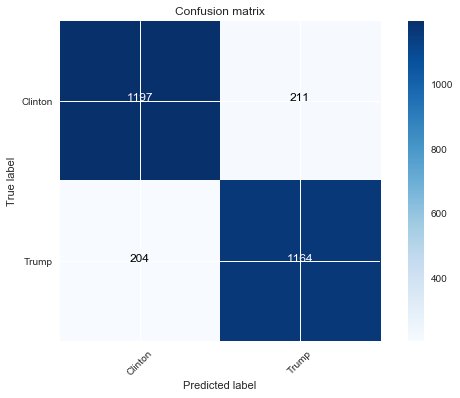

In [59]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Code adapted from http://scikit-learn.org/
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(y_test, test_predictions)
plot_confusion_matrix(cm, ['Clinton', 'Trump'])

The confusion matrix plot confirms what we've seen from the calculated performance metrics: under each metric, __the SVN correctly identifies ~ 85% of the tweets__ as coming from Trump or Clinton.

But what about the new features we generated in part 2: will the SVM's predictive ability improve if we add them to our feature vectors?  

----
# 6. The SVM: With New Features Added

## 6.1 Re-training the SVM

__Let's see if we can improve the performance of our SVM by including some of the new features we created above in part 2,__ in addition to the features generated from vocabulary list word stems.  For each tweet, we'll change all the '0' values to '-1', such that all elements are either +1 or -1.  Then we'll add values for the following features at the end of our vocabulary feature vector:

  * __Binary features (0 or 1):__ `contains_picture`, `is_quotation`
  * __Continuous features:__ `exclamation_count`, `hashtag_count`, `mention_count`, `allcaps_ratio`, `avg_wordlength`, `time_of_day`, `sentiment`

For the unbounded continuous features (e.g., `exclamation_count`) we'll scale the values by substituting their distance from the mean value, in units of standard deviation:

$$x_i~\rightarrow~\dfrac{x_i~-~\bar{x}}{\sigma_x}$$

This prevents features with large value ranges from dominating the model's fit.  We'll also conform the bounded features (e.g., `allcaps_ratio`) so all of them range from -1 to 1.  

The new, extended feature vector for each tweet will consist of the vocabulary feature vector defined above, plus 9 additional elements at the bottom of the column vector, corresponding to the rescaled values for the 9 new features.

Then we'll create extended versions of the feature matrix `X` and label vector `y` for the training, cross-validation, and test sets; re-do our analysis to identify the optimal $C$ value; and test the optimal SVM on our test set.

In [60]:
def get_scaled_feature_column(data, feature):
    scaled_feature = (data[feature] - data[feature].mean())/data[feature].std()
    return scaled_feature.values.astype(float)

avg_wordlength = get_scaled_feature_column(data, 'avg_wordlength')
exclamation_count = get_scaled_feature_column(data, 'exclamation_count')
hashtag_count = get_scaled_feature_column(data, 'hashtag_count')
mention_count = get_scaled_feature_column(data, 'mention_count')
allcaps_ratio = (2. * data.allcaps_ratio.values) - 1. 
contains_picture = (2. * data.contains_picture.values.astype(int)) - 1. 
time_of_day = get_scaled_feature_column(data, 'time_of_day')
is_quotation = (2. * data.is_quotation.values.astype(int)) - 1.
sentiment = data.sentiment.values 

new_features = [avg_wordlength, exclamation_count, hashtag_count, mention_count,
               allcaps_ratio, contains_picture, time_of_day, is_quotation, sentiment]
    
def get_extended_feature_vector(data, tweet_idx, vocab_list):
    tweet = data.text.values[tweet_idx]
    feature_vector = generate_feature_vector(tweet, vocab_list)
    # change feature_vector values from [0,1] to [-1,1]
    feature_vector = (2 * feature_vector) - 1
    for new_feature in new_features:
        value = new_feature[tweet_idx] 
        if pl.isnan(value):
            value = np.nanmean(new_feature)
        feature_vector = np.vstack((feature_vector, np.array(value)))
    return feature_vector

# test one tweet:
f = get_extended_feature_vector(data, 0, vocab_list)
print f.shape

(1921, 1)


In [61]:
X_train_ext, y_train_ext = \
    get_feature_matrix_and_label_vector(data, vocab_list, train_idxs, 
                                        use_extended_features=True)
print 'Traning set: X.shape = %s, y.shape = %s' % (X_train_ext.shape, y_train_ext.shape)
        
X_cv_ext, y_cv_ext = \
    get_feature_matrix_and_label_vector(data, vocab_list, cv_idxs,
                                        use_extended_features=True)
print 'CV set: X.shape = %s, y.shape = %s' % (X_cv_ext.shape, y_cv_ext.shape)

X_test_ext, y_test_ext = \
    get_feature_matrix_and_label_vector(data, vocab_list, test_idxs, 
                                        use_extended_features=True)
print 'Test set: X.shape = %s, y.shape = %s' % (X_test_ext.shape, y_test_ext.shape)

Traning set: X.shape = (8326, 1921), y.shape = (8326, 1)
CV set: X.shape = (2775, 1921), y.shape = (2775, 1)
Test set: X.shape = (2776, 1921), y.shape = (2776, 1)


In [62]:
Cs = [1e-4, 1e-3, 1e-2, 0.1, 1., 10.]
errors_cv_ext, errors_train_ext = [], []

for C in Cs:
    linear_svm = svm.SVC(C=C, kernel='linear') 
    linear_svm.fit(X_train_ext, y_train_ext.flatten()) 
    
    cv_predictions = linear_svm.predict(X_cv_ext).reshape((y_cv_ext.shape[0],1))
    cv_error = float(sum(cv_predictions != y_cv_ext))/y_cv_ext.shape[0] * 100.
    errors_cv_ext.append(cv_error)

    train_predictions = linear_svm.predict(X_train_ext).reshape((y_train_ext.shape[0],1))
    training_error = float(sum(train_predictions != y_train_ext))/y_train_ext.shape[0] * 100. 
    errors_train_ext.append(training_error)

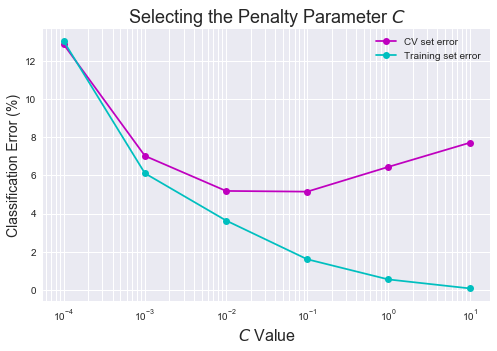

In [63]:
plot_errors_vs_C(Cs, errors_cv_ext, errors_train_ext)

It looks like $C~=~0.05$ is a good choice (although any value between $\sim$ 0.01 to 0.1 would do).  We'll train our SVM using this optimized value for use on our test set:

In [64]:
optimal_svm_ext = svm.SVC(C=0.05, kernel='linear')
optimal_svm_ext.fit(X_train_ext, y_train_ext.flatten())

train_predictions_ext = optimal_svm_ext.predict(X_train_ext).reshape((y_train_ext.shape[0],1))
cv_predictions_ext = optimal_svm_ext.predict(X_cv_ext).reshape((y_cv_ext.shape[0],1))
test_predictions_ext = optimal_svm_ext.predict(X_test_ext).reshape((y_test_ext.shape[0],1))

In [65]:
train_accuracy_ext = 100. * float(sum(train_predictions_ext==y_train_ext))/y_train_ext.shape[0]
print 'Extended Training Set Accuracy = %0.2f%%' % train_accuracy_ext

cv_accuracy_ext = 100. * float(sum(cv_predictions_ext==y_cv_ext))/y_cv_ext.shape[0]
print 'Extended Cross-Calidation Set Accuracy = %0.2f%%' % cv_accuracy_ext

test_accuracy_ext = 100. * float(sum(test_predictions_ext==y_test_ext))/y_test_ext.shape[0]
print 'Extended Test Set Accuracy = %0.2f%%' % test_accuracy_ext

Extended Training Set Accuracy = 97.69%
Extended Cross-Calidation Set Accuracy = 94.92%
Extended Test Set Accuracy = 95.32%


And there we have it: __the test set accuracy increases to 95% when the new features are included.__  

## 6.2 Performance assessment

Let's end by looking again at our misclassified tweets, our most-predictive words, and our re-calculated performance metrics (F-score, MCC, and confusion matrix).  As before, we should keep in mind that a complete analysis would estimate the significance of the performance scores by applying a $k$-fold evaluation (which can be automated, e.g., by using [`sklearn.model_selection.permutation_test_score()`](http://scikit-learn.org/stable/auto_examples/feature_selection/plot_permutation_test_for_classification.html)).

In [66]:
predictions_ext = np.concatenate((train_predictions_ext, cv_predictions_ext, 
                             test_predictions_ext), axis=0)
sorted_predictions_ext = []

for j in range(num_training_samples):
    idx = randomized_idxs[j]
    prediction = predictions_ext[j]
    if prediction == 1:
        sorted_predictions_ext.append('Trump')
    else:
        sorted_predictions_ext.append('Clinton')
        
for j in range(num_training_samples, 
               num_training_samples+num_cv_samples):
    idx = randomized_idxs[j]
    prediction = predictions_ext[j]
    if prediction == 1:
        sorted_predictions_ext.append('Trump')
    else:
        sorted_predictions_ext.append('Clinton')

for j in range(num_training_samples+num_cv_samples, 
               num_rows):
    idx = randomized_idxs[j]
    prediction = predictions_ext[j]
    if prediction == 1:
        sorted_predictions_ext.append('Trump')
    else:
        sorted_predictions_ext.append('Clinton')

data['predicted_user_ext'] = sorted_predictions_ext
wrong_predictions_ext = data[data.user != data.predicted_user_ext]

pd.set_option('display.max_colwidth', -1)
wrong_predictions_ext[['user','predicted_user_ext','text']]

,user,predicted_user_ext,text
18,Trump,Clinton,"""@one4eternity: !!!!!!! RT @realDonaldTrump: ""@BalkesGirl: @realDonaldTrump @ApprenticeNBC this show ROCKS!!!!"""""
25,Trump,Clinton,"""@MrLWord: @realDonaldTrump Donald Trump for president"""
36,Trump,Clinton,"""@MichelleRenee_V: @ApprenticeNBC It MUST be @LeezaGibbons because she is well rounded, hardworking, kind &amp; professional. SHE'S HIRED! 🎉"""
78,Trump,Clinton,"""@ReillyCarole: @realDonaldTrump .We all need to get out and vote for Donald . We need a change and he is the man to bring it ."" Thank you!"
97,Trump,Clinton,"""@MeetinLongBeach: @TrumpGolfLA @RepostApp @PGAGrandSlam Looking forward to welcoming this event to the Greater #LongBeach area! #MeetinLB"""
112,Trump,Clinton,"Why didn't the writer of the twelve year old article in People Magazine mention the ""incident"" in her story. Because it did not happen!"
125,Trump,Clinton,"""@Ravenrantz: #Billygraham's grand daughter #SupportsTrump https://t.co/sKz1SPHzDZ"" So nice, thank you Cissy Graham Lynch!!!!"
130,Trump,Clinton,This boardroom gets CRAZY! These people are wild
139,Trump,Clinton,"""@Pg1493: @realDonaldTrump I love what you want to do with this country!!"""
145,Trump,Clinton,"""@troyconway: Now 2-more IT Firms going over seas? There is a huge difference between a global economy and GREED! #MakeAmericaGreatAgain"


In [67]:
weights_ext = optimal_svm_ext.coef_[0]
sorted_indices_ext = np.array(weights_ext).argsort()[::-1] # get the indices in descending order of the weights

predictive_words_ext = []

for index in sorted_indices_ext[:15]:
    for word in vocab_list.keys():
        if vocab_list[word] == index:
            predictive_words_ext.append(word)

print 'MOST PREDICTIVE PRESIDENTIAL WORD STEMS:\n', predictive_words_ext

MOST PREDICTIVE PRESIDENTIAL WORD STEMS:
['crook', 'total', 'berni', 'bad', 'great', 'bush', 'illeg', 'border', 'cruz', 'product', 'speech']


Precision:	0.95
Recall:  	0.95
F-score:	0.95

MCC:	0.91 

Confusion matrix, without normalization
[[1340   68]
 [  62 1306]]


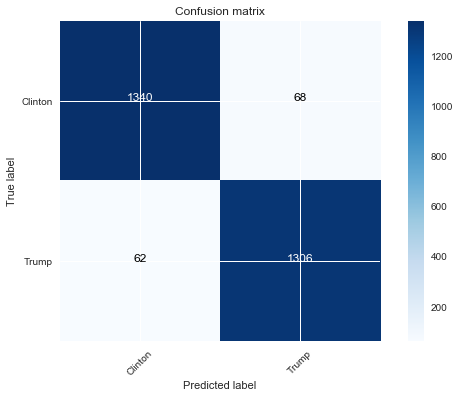

In [68]:
# Re-do the F-score calculation:
calculate_F_score(test_predictions_ext, y_test_ext)
print 

# Re-do the MCC calculation:
mcc_ext = sklearn.metrics.matthews_corrcoef(y_test_ext, test_predictions_ext)
print 'MCC:\t%.2f \n' % mcc_ext

# Print the new confusion matrix:
cm_ext = confusion_matrix(y_test_ext, test_predictions_ext)
plot_confusion_matrix(cm_ext, ['Clinton', 'Trump'])

----
# 7. Comparison to Naive Bayes:


Naive Bayes classifiers are based on applying Bayes’ theorem with the "naive" assumption that every pair of features is independent.  They have several features that make them an attractive to our SVM classifier for this particular problem (see the [`scikit-learn.naive_bayes` documentation](http://scikit-learn.org/stable/modules/naive_bayes.html)):

  * Despite their apparently over-simplified assumptions, they function well in many situations, including document classification and spam filtering.
  * They are much faster than more sophisticated methods. 
  * The `MultinomialNB` function implements the naive Bayes algorithm for multinomially distributed data, and is ooften employed in text classification problems where the data are represented as word vector counts.

## 7.1 Naive Bayes: Vocabulary List Features Only

Multinomial Naive Bayes treats features as event probabilities, which must lie between [0, 1].  For our extended features we'll need to re-scale them accordingly.  For our initial run including solely the vocabulary word features (where "0" and "1" indicate absence/presence of a vocabulary word stem), we can apply the algorithm directly:

NAIVE BAYES CLASSIFIER:

             precision    recall  f1-score   support

          0       0.85      0.86      0.85      1408
          1       0.85      0.84      0.85      1368

avg / total       0.85      0.85      0.85      2776


MCC: 0.698053988232

Confusion matrix, without normalization
[[1205  203]
 [ 216 1152]]


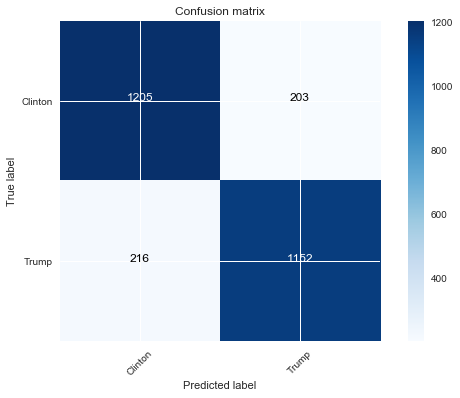

In [69]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train.flatten())

expected = y_test
predicted = model.predict(X_test)#.reshape((y_test_ext.shape[0],1))

# summarize the fit of the model
print 'NAIVE BAYES CLASSIFIER:\n'
print sklearn.metrics.classification_report(expected, predicted)
print '\nMCC: %s\n' % sklearn.metrics.matthews_corrcoef(expected, predicted)
cm_naive_bayes = sklearn.metrics.confusion_matrix(expected, predicted)
plot_confusion_matrix(cm_naive_bayes, ['Clinton', 'Trump'])

We can see that when only the vocabulary list features are included, the Naive Bayes classifier performs as well as our SVM.

## 7.2 Naive Bayes: With New Features

Let's try applying our Naive Bayes classifier with the new features included.  First we'll have to rescale them to confom to the interval [0,1]:

In [70]:
def get_scaled_feature_column_NB(data, feature):
    scaled_feature = copy.copy(data[feature].values).astype(float)
    valid = ~pl.isnan(scaled_feature)
    feature_range = (np.max(scaled_feature[valid]) - np.min(scaled_feature[valid]))
    scaled_feature /= feature_range
    scaled_feature -= np.min(scaled_feature[valid])
    return scaled_feature

avg_wordlength_NB = get_scaled_feature_column_NB(data, 'avg_wordlength')
exclamation_count_NB = get_scaled_feature_column_NB(data, 'exclamation_count')
hashtag_count_NB = get_scaled_feature_column_NB(data, 'hashtag_count')
mention_count_NB = get_scaled_feature_column_NB(data, 'mention_count')
allcaps_ratio_NB = get_scaled_feature_column_NB(data, 'allcaps_ratio')
contains_picture_NB = data.contains_picture.values.astype(int)
time_of_day_NB = get_scaled_feature_column_NB(data, 'time_of_day')
is_quotation_NB = data.is_quotation.values.astype(int)
sentiment_NB = get_scaled_feature_column_NB(data, 'sentiment')

new_features_NB = [avg_wordlength_NB, exclamation_count_NB, hashtag_count_NB, 
                   mention_count_NB, allcaps_ratio_NB, contains_picture_NB, 
                   time_of_day_NB, is_quotation_NB, sentiment_NB]

def get_extended_feature_vector_NB(data, tweet_idx, vocab_list):
    """
    A function that generates a feature vector from the tweet text
    in a row of the data frame for use with the Naive Bayes classifier.
    Input:  data = pandas.DataFrame containing the text of tweets
            tweet_idx = index of a specific tweet in data
            vocab_list = list of words to include as features
    Output: feature_vector, consisting of a vetical stack of 
      (1) vocabulary list features from generate_feature_vector() and
      (2) new features in new_features_NB.
    """
    tweet = data.text.values[tweet_idx]
    feature_vector = generate_feature_vector(tweet, vocab_list) # [0,1]
    for new_feature in new_features_NB:
        value = new_feature[tweet_idx]
        if pl.isnan(value):
            value = np.nanmedian(new_feature)
        feature_vector = np.vstack((feature_vector, np.array(value)))
    return feature_vector


In [71]:
def get_X_y_NB(df, vocab_list, randomized_idxs_slice):                                     
    X_vectors, y_labels = [], []
    for idx in randomized_idxs_slice:
        features = get_extended_feature_vector_NB(df, idx, vocab_list)
        X_vectors.append(features)
        if df.user.values[idx] == 'Trump':
            y_labels.append(1)
        else:
            y_labels.append(0)
    X = np.concatenate(X_vectors, axis=1).T
    y = np.array([y_labels]).T
    return X, y

X_train_NB, y_train_NB = get_X_y_NB(data, vocab_list, train_idxs)
print 'Traning set: X.shape = %s, y.shape = %s' % (X_train_NB.shape, y_train_NB.shape)
        
X_cv_NB, y_cv_NB = get_X_y_NB(data, vocab_list, cv_idxs)
print 'CV set: X.shape = %s, y.shape = %s' % (X_cv_NB.shape, y_cv_NB.shape)

X_test_NB, y_test_NB = get_X_y_NB(data, vocab_list, test_idxs)
print 'Test set: X.shape = %s, y.shape = %s' % (X_test_NB.shape, y_test_NB.shape)

Traning set: X.shape = (8326, 1921), y.shape = (8326, 1)
CV set: X.shape = (2775, 1921), y.shape = (2775, 1)
Test set: X.shape = (2776, 1921), y.shape = (2776, 1)


NAIVE BAYES CLASSIFIER, AUGMENTED WITH NEW FEATURES:

             precision    recall  f1-score   support

          0       0.92      0.93      0.93      1408
          1       0.93      0.92      0.93      1368

avg / total       0.93      0.93      0.93      2776


MCC: 0.853743129672

Confusion matrix, without normalization
[[1314   94]
 [ 109 1259]]


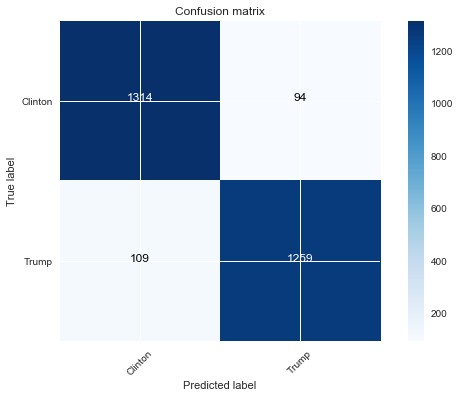

In [72]:
model_NB = MultinomialNB()
model_NB.fit(X_train_NB, y_train_NB.flatten())

expected_NB = y_test_NB
predicted_NB = model_NB.predict(X_test_NB)

# summarize the fit of the model
print 'NAIVE BAYES CLASSIFIER, AUGMENTED WITH NEW FEATURES:\n'
print sklearn.metrics.classification_report(expected_NB, predicted_NB)
print '\nMCC: %s\n' % sklearn.metrics.matthews_corrcoef(expected_NB, predicted_NB)
cm_naive_bayes_NB = sklearn.metrics.confusion_matrix(expected_NB, predicted_NB)
plot_confusion_matrix(cm_naive_bayes_NB, ['Clinton', 'Trump'])

## 7.3 Conclusions:

We can summarize our conclusions as follows:
  1. Naive Bayes classification performs as well as our SVM classifier for feature vectors based on vocabulary list word stems alone (85% accuracy).
  2. __When the features are augmented with our new features, the SVM provides a small advantage__ in terms of misclassification error: 95% accuracy (SVM) vs 93% accuracy (Naive Bayes).
  3. If processing time is not a concern (e.g., if the data set we're working with is small, or if our analysis is run using parallel processing), SVM provides a slight advantage.  __To the extent that processing time is a concern -- and if we are willing to sacrifice 2% accuracy -- Naive Bayes provides an efficient alternative to our SVM classifier.__

__Next Steps:__  Possible next steps for further development include:
  * Implementing __$k$-fold cross-validation,__ as well as __$k$-fold performance evaluation__ to estimate the significance of the performance metrics.
  * Using a __vocabulary list generated from a (large) subset of Trump tweets,__ rather than from Trump campaign speeches.
  * Implementing __multi-class classification__ to distinguish tweets among multiple candidates (e.g., Sanders, Cruz, Bush).  This can be achieved by turning multi-class classification into binary classification using a one-vs-one or one-vs-all strategy (also available in [`sklearn`](http://scikit-learn.org/stable/modules/multiclass.html)), or by using an alternative classification algorithm (e.g., random forest).
  
  
----